# INTRODUCTION
----------------------------------------------------

TITLE - Semantic Hotel Likeability Ranker

This notebook builds a **semantic hotel likeability ranker** using **BigQuery + Vertex AI text embeddings**. It runs a one-off backend step to create hotel-level “master” embeddings and a **vector index** in BigQuery, then simulates a frontend journey for specific users: fetch their past reviews, produce a **query embedding** that reflects what they liked, perform a **vector search** over hotel embeddings, re-rank results, and visualize why the top hotels match their historical preferences.

In short, the flow is as follows:
1. Configure project + connections in one place.  
2. Generate **master hotel embeddings**.  
3. Fetch user profile/history and generate a **user preference query embedding**.  
4. Run **semantic search** in BigQuery to retrieve similar hotels.  
5. Score, re-rank, and explain matches with lightweight visual summaries.

In [1]:
print("📦 Installing required packages...")

from google.cloud import bigquery

from google.api_core.exceptions import Conflict
from google.cloud.exceptions import NotFound

import warnings
import logging
import time

from typing import Optional, List, Union, Any

from IPython.display import display, Markdown, HTML
from textwrap import shorten

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json

import re
import unicodedata

from html import escape as html_escape
import io, base64

print("\n✅ All packages installed successfully!")

📦 Installing required packages...


ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# Configure environment
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('HotelRanker')

print("\n✅ Environment configuration successful!")


✅ Environment configuration successful!


# SECTION 1: PROJECT CONFIGURATION - holds shared project settings
----------------------------------------------------

**One-off activities**

1. Enable Vertex AI APIs
2. Create a runtime in Colab
3. Create a remote connection following this URL - https://cloud.google.com/bigquery/docs/generate-text-embedding.
4. Provide access (roles/aiplatform.user) to the Service account ID (generated from step 3)
5. Create models using the remote connection, directly in BigQuery(BQ)


#### Query to create text embedding model - *used to generate master and user query embeddings*

```
CREATE OR REPLACE MODEL `<project_id>.<dataset_id>.text_embedding_model` REMOTE
WITH CONNECTION `vf-it-aib-prd-hr-ask-web-nl.europe-west1.bq_text_embedding_conn`
OPTIONS (ENDPOINT = 'gemini-embedding-001');
```

#### Query to create gemini flash model - *used to generate user preferences*


```
CREATE OR REPLACE MODEL `<project_id>.<dataset_id>.gemini_2_flash_model` REMOTE
WITH CONNECTION `vf-it-aib-prd-hr-ask-web-nl.europe-west1.bq_text_embedding_conn`
OPTIONS (ENDPOINT = 'gemini-2.0-flash-001');
```


In [ ]:
class Config:
    """
    Configuration holder for data cleaning and processing, embedding and search operations.
    """
    def __init__(self, project_id: str, dataset_id: str, region: str,
                 embedding_model: str):
        self.project_id = project_id
        self.dataset_id = dataset_id
        self.region = region
        self.embedding_model = embedding_model
        self.bq_client = bigquery.Client(project=project_id)

        self.table_name = "kaggle_to_bq_table_4"

        self.master_raw_table = "combined_data"

        self.master_embeddings_table = "master_embeddings_table"
        self.master_embeddings_columns = ["customer_country","cust_gender",\
                                 "booking_destination_country","booking_destination_city",\
                                 "no_of_guests","cust_type_of_travel",\
                                 "hotel_id","hotel_name","review_text","positive_review","hotel_average_rating",\
                                 "booking_tags","review_overall_rating","booking_id"]

        self.master_embeddings_default_index_name = "default_ivf_index"

        # index that is curerntly being used
        self.master_embeddings_index_name="master_embeddings_ivf_index"


        self.user_search_embedding_table = "user_search_embedding"
        self.user_search_columns = ["customer_id","customer_country","booking_destination_country","booking_destination_city","no_of_guests",
                                    "cust_type_of_booking", "cust_type_of_travel","booking_id",
                                    "hotel_id","hotel_name","review_text","positive_review","negative_review"]

        self.user_search_embeddings_columns = ["customer_country","booking_destination_country","booking_destination_city","no_of_guests",
                                               "cust_type_of_travel","cust_type_of_booking",
                                               "hotel_id","hotel_name","review_text","positive_review"]


        # stores information related to master indexes
        indexes = {
                      "default_ivf_index": {
                           "name": "default_ivf_index",
                           "type":"IVF",
                           "distance_type":"COSINE",
                           "options":'{"num_lists":500}'

                       },
                       "master_embeddings_ivf_index": {
                           "name": "master_embeddings_ivf_index_via_code",
                           "type":"IVF",
                           "distance_type":"COSINE",
                           "options":'{"num_lists":500}'

                       },
                       "master_embeddings_ta_index": {
                           "name": "master_embeddings_ta_index_via_code",
                           "type":"TREE_AH",
                           "distance_type":"COSINE",
                           "options":'{"normalization_type": "L2"}'

                       }
                   }

        self.master_embeddings_indexes = indexes

# SECTION 2: DATA PREPARATION AND CLEANSING
----------------------------------------------------

Fetches two raw datasets (customer profiles and hotel reviews) from Kaggle, cleans and transforms them into a **single analytics-ready table** used later for embedding generation and search. It standardizes columns, synthesizes labeled review text, aligns nationalities, enriches reviews with customer attributes, derives destination fields, assigns stable IDs, and **publishes the cleaned table into BigQuery**.

##### Steps involved are as follows:
1. **Load customer dataset** (`hotel_customer.csv`) and keep only needed columns; rename to consistent, analysis-friendly names (e.g., `ID -> customer_id`, `Age -> cust_age`).  
2. **Load hotel reviews dataset** (`Hotel_Reviews.csv`), subset/rename key fields (hotel name/address, reviewer country, positive/negative text, scores, dates). Build a single `review_text` column by concatenating *Negative Review:* and *Positive Review:* (also skipping placeholders like “No Negative/No Positive”).  
3. **Normalize nationalities** to ISO-3 codes and **link reviewers to customers**: map `reviewer_nationality -> reviewer_iso3`, then, for each review, pick a matching customer to enrich with attributes (gender, age, booking/travel types, etc.).  
4. **Derive destination country** from `hotel_address` using a curated country list/aliases - `booking_destination_country`.  
5. **Derive destination city** from `hotel_address` using a city mapping - `booking_destination_city`.  
6. **Synthesize booking context**: infer `no_of_guests` from `cust_type_of_booking` and `cust_type_of_travel`; standardize field names (e.g., `average_score -> hotel_average_rating`, `reviewer_nationality -> customer_country`, `reviewer_score -> review_overall_rating`, `tags -> booking_tags`).  
7. **Assign stable identifiers**:  
   - `hotel_id`: first-seen index per normalized `hotel_address` (consistent across rows).  
   - `booking_id`: sequential row ID (1..N) after resetting index.  
   Reorder columns (dates → hotel → customer → review → booking) for readability.  
8. **Publish to BigQuery** with **WRITE_TRUNCATE**, then **verify row counts**.  
   
**Outcome:** a **single, tidy table** blending customer context + labeled review text + destination fields + stable IDs—ready for **ML.GENERATE_EMBEDDING**, vector search, and personalized ranking in later sections.


In [ ]:
# A basic check to ensure data cleaning and processing is performed only if master table does not exist in BigQuery

config = Config(
    project_id="vf-it-aib-prd-hr-ask-web-nl",
    dataset_id="bq_ai_hackathon",
    region="europe-west1",
    embedding_model="text_embedding_model"
)

TABLE_ID = f"{config.project_id}.{config.dataset_id}.{config.table_name}"

client = config.bq_client

def bq_table_exists(client: client, table_id: str) -> bool:
    try:
        client.get_table(table_id)
        return True
    except NotFound:
        return False

MASTER_EXISTS = bq_table_exists(client, TABLE_ID)
RUN_PREP = not MASTER_EXISTS

if MASTER_EXISTS:
    print(f"✅ Master table already exists: {TABLE_ID}. Data Cleansing & Preparation will be SKIPPED.")
else:
    print(f"🚀 Master table not found. Data Cleansing & Preparation will RUN and create: {TABLE_ID}")


✅ Master table already exists: vf-it-aib-prd-hr-ask-web-nl.bq_ai_hackathon.kaggle_to_bq_table_4. Data Cleansing & Preparation will be SKIPPED.


In [ ]:
# Step 1: Load customer dataset

if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    customer_path = "/kaggle/input/customer-of-a-hotel/hotel_customer.csv"
    customer_csv = pd.read_csv(customer_path)
    
    print("Customer CSV Dataset Shape:", customer_csv.shape)
    
    display(customer_csv.head())

⏭️ Skipping Data Preparation (master table exists).


In [ ]:
# Step 2: Clean the customer dataset

if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    ## Keep only desired columns
    customer_csv = customer_csv[['Unnamed: 0', 'Nationality', 'Age', 'Gender', 'Type.of.Travel', 'Type.Of.Booking', 'satisfaction']]
    
    ## Format column names
    customer_csv = customer_csv.rename(columns={'Unnamed: 0': 'customer_id', 'Nationality': 'nationality', 'Age': 'age', 'Gender': 'gender', 'Type.of.Travel': 'type_of_travel', 'Type.Of.Booking': 'type_of_booking'})
    display(customer_csv.head())

⏭️ Skipping Data Preparation (master table exists).


In [ ]:
# Step 3: Load hotel dataset

if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    hotel_path = "/kaggle/input/515k-hotel-reviews-data-in-europe/Hotel_Reviews.csv"
    hotel_csv = pd.read_csv(hotel_path)
    
    print("Hotel CSV Dataset Shape:", hotel_csv.shape)
    
    display(hotel_csv.head())

⏭️ Skipping Data Preparation (master table exists).


In [ ]:
# Step 4: Clean the hotel dataset

if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    ## Keep only desired columns
    hotel_csv = hotel_csv[['Hotel_Address', 'Review_Date', 'Average_Score', 'Hotel_Name', 'Reviewer_Nationality', 'Negative_Review', 'Total_Number_of_Reviews', 'Positive_Review', 'Reviewer_Score', 'Tags']]
    
    ## Format column names
    hotel_csv = hotel_csv.rename(columns={'Hotel_Address': 'hotel_address', 'Review_Date': 'review_date', 'Average_Score': 'average_score', 'Hotel_Name': 'hotel_name', 'Reviewer_Nationality': 'reviewer_nationality', 'Total_Number_of_Reviews': 'total_reviews', 'Reviewer_Score': 'reviewer_score', 'Tags': 'tags', 'Positive_Review': 'positive_review', 'Negative_Review': 'negative_review'})


# ---------------------------------------------------------------------------
# Step 5: Create a column with combined negative and positive reviews text

if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    ## Normalize to strings and trim
    neg = hotel_csv['negative_review'].fillna('').astype(str).str.strip()
    pos = hotel_csv['positive_review'].fillna('').astype(str).str.strip()
    
    ## Remove placeholders (case-insensitive)
    neg = neg.mask(neg.str.fullmatch(r'(?i)\s*no\s*negative\s*'), '')
    pos = pos.mask(pos.str.fullmatch(r'(?i)\s*no\s*positive\s*'), '')
    
    ## Prepend labels only if there is content
    neg_labeled = ('Negative Review: ' + neg).where(neg != '', '')
    pos_labeled = ('Positive Review: ' + pos).where(pos != '', '')
    
    ## Add a separator only when both parts exist
    sep = pd.Series(np.where((neg_labeled != '') & (pos_labeled != ''), ' | ', ''),
                    index=hotel_csv.index)
    
    ## Final concatenation
    hotel_csv['review_text'] = neg_labeled + sep + pos_labeled
    
    display(hotel_csv.head())

⏭️ Skipping Data Preparation (master table exists).
⏭️ Skipping Data Preparation (master table exists).


In [ ]:
# Step 6: Perform country mapping for reviewer_nationality

if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    hotel_csv['reviewer_nationality'] = hotel_csv['reviewer_nationality'].str.strip()
    
    country_map = {
        "Afghanistan": "AFG",
        "Albania": "ALB",
        "Algeria": "DZA",
        "Andorra": "AND",
        "Angola": "AGO",
        "Anguilla": "AIA",
        "Antigua Barbuda": "ATG",
        "Argentina": "ARG",
        "Armenia": "ARM",
        "Aruba": "ABW",
        "Australia": "AUS",
        "Austria": "AUT",
        "Azerbaijan": "AZE",
        "Bahamas": "BHS",
        "Bahrain": "BHR",
        "Bangladesh": "BGD",
        "Barbados": "BRB",
        "Belarus": "BLR",
        "Belgium": "BEL",
        "Belize": "BLZ",
        "Benin": "BEN",
        "Bermuda": "BMU",
        "Bhutan": "BTN",
        "Bolivia": "BOL",
        "Bosnia and Herzegovina": "BIH",
        "Botswana": "BWA",
        "Brazil": "BRA",
        "Bulgaria": "BGR",
        "Cambodia": "KHM",
        "Cameroon": "CMR",
        "Canada": "CAN",
        "Cape Verde": "CPV",
        "Chile": "CHL",
        "China": "CHN",
        "Colombia": "COL",
        "Costa Rica": "CRI",
        "Croatia": "HRV",
        "Cuba": "CUB",
        "Cyprus": "CYP",
        "Czech Republic": "CZE",
        "Denmark": "DNK",
        "Dominican Republic": "DOM",
        "Ecuador": "ECU",
        "Egypt": "EGY",
        "El Salvador": "SLV",
        "Estonia": "EST",
        "Ethiopia": "ETH",
        "Finland": "FIN",
        "France": "FRA",
        "Georgia": "GEO",
        "Germany": "DEU",
        "Greece": "GRC",
        "Guatemala": "GTM",
        "Guyana": "GUY",
        "Haiti": "HTI",
        "Honduras": "HND",
        "Hong Kong": "HKG",
        "Hungary": "HUN",
        "Iceland": "ISL",
        "India": "IND",
        "Indonesia": "IDN",
        "Iran": "IRN",
        "Iraq": "IRQ",
        "Ireland": "IRL",
        "Israel": "ISR",
        "Italy": "ITA",
        "Ivory Coast": "CIV",
        "Jamaica": "JAM",
        "Japan": "JPN",
        "Jordan": "JOR",
        "Kazakhstan": "KAZ",
        "Kenya": "KEN",
        "Kuwait": "KWT",
        "Kyrgyzstan": "KGZ",
        "Latvia": "LVA",
        "Lebanon": "LBN",
        "Lithuania": "LTU",
        "Luxembourg": "LUX",
        "Macau": "MAC",
        "Macedonia": "MKD",
        "Madagascar": "MDG",
        "Malaysia": "MYS",
        "Maldives": "MDV",
        "Malta": "MLT",
        "Mexico": "MEX",
        "Moldova": "MDA",
        "Monaco": "MCO",
        "Mongolia": "MNG",
        "Montenegro": "MNE",
        "Morocco": "MAR",
        "Mozambique": "MOZ",
        "Myanmar": "MMR",
        "Namibia": "NAM",
        "Nepal": "NPL",
        "Netherlands": "NLD",
        "New Zealand": "NZL",
        "Nicaragua": "NIC",
        "Niger": "NER",
        "Nigeria": "NGA",
        "Norway": "NOR",
        "Oman": "OMN",
        "Pakistan": "PAK",
        "Panama": "PAN",
        "Paraguay": "PRY",
        "Peru": "PER",
        "Philippines": "PHL",
        "Poland": "POL",
        "Portugal": "PRT",
        "Puerto Rico": "PRI",
        "Qatar": "QAT",
        "Romania": "ROU",
        "Russia": "RUS",
        "Saudi Arabia": "SAU",
        "Senegal": "SEN",
        "Serbia": "SRB",
        "Singapore": "SGP",
        "Slovakia": "SVK",
        "Slovenia": "SVN",
        "South Africa": "ZAF",
        "South Korea": "KOR",
        "Spain": "ESP",
        "Sri Lanka": "LKA",
        "Sudan": "SDN",
        "Suriname": "SUR",
        "Sweden": "SWE",
        "Switzerland": "CHE",
        "Syria": "SYR",
        "Taiwan": "TWN",
        "Tanzania": "TZA",
        "Thailand": "THA",
        "Trinidad and Tobago": "TTO",
        "Tunisia": "TUN",
        "Turkey": "TUR",
        "Uganda": "UGA",
        "Ukraine": "UKR",
        "United Arab Emirates": "ARE",
        "United Kingdom": "GBR",
        "United States of America": "USA",
        "United States": "USA",
        "Uruguay": "URY",
        "Uzbekistan": "UZB",
        "Venezuela": "VEN",
        "Vietnam": "VNM",
        "Yemen": "YEM",
        "Zambia": "ZMB",
        "Zimbabwe": "ZWE"
    }
    
    ## Apply country mapping
    hotel_csv['reviewer_iso3'] = hotel_csv['reviewer_nationality'].map(lambda x: country_map.get(x.strip()) if pd.notna(x) else None)
    
    ## Drop unmapped rows
    hotel_csv = hotel_csv.dropna(subset=['reviewer_iso3'])
    
    ## Build a lookup: nationality ISO3 -> list of customer row indices
    cust_indexed = customer_csv.reset_index()  # keep original row index for lookup
    cust_buckets = (
        cust_indexed.groupby('nationality')['index']
        .apply(list)
        .to_dict()
    )
    
    ## Pick one random customer per review, matching on ISO3
    rng = np.random.default_rng(seed=42)
    
    def pick_customer_index(iso3: str):
        bucket = cust_buckets.get(iso3)
        if not bucket:  # no customers for this nationality
            return np.nan
        return rng.choice(bucket)  # with replacement (simple and realistic for large datasets)
    
    hotel_csv['picked_cust_idx'] = hotel_csv['reviewer_iso3'].apply(pick_customer_index)
    hotel_csv = hotel_csv.dropna(subset=['picked_cust_idx'])
    hotel_csv['picked_cust_idx'] = hotel_csv['picked_cust_idx'].astype(int)
    
    ## Pull those customer rows and prefix their columns to avoid name clashes
    customers_matched = (
        cust_indexed.set_index('index')
        .loc[hotel_csv['picked_cust_idx']]
        .reset_index(drop=True)
    )
    
    ## Adding prefix to columns from customer table
    customers_matched_pref = customers_matched.add_prefix('cust_')
    
    ## Assemble the combined dataset
    combined = pd.concat(
        [
            hotel_csv.reset_index(drop=True),
            customers_matched_pref
        ],
        axis=1
    )
    
    ## Curate final columns for a clean schema
    ## Safely select only columns that actually exist
    def keep(cols):
        return [c for c in cols if c in combined.columns]
    
    final_cols = keep([
        # review-side
        'review_date', 'hotel_name', 'hotel_address', 'average_score', 'review_text', 'positive_review',
        'negative_review', 'reviewer_nationality', 'reviewer_iso3', 'reviewer_score', 'tags',
        # customer-side (prefixed)
        'cust_customer_id', 'cust_age', 'cust_gender',
        'cust_type_of_travel', 'cust_type_of_booking', 'cust_satisfaction',
        'cust_nationality'
    ])
    
    if final_cols:  # if exact names differ, keep the full combined instead
        combined = combined[final_cols]
    
    ## Light cleanups
    combined['review_date'] = pd.to_datetime(combined['review_date'], errors='coerce')
    combined = combined.dropna(subset=['review_text'])
    combined = combined[combined['review_text'].str.len() > 0]
    combined = combined[['review_date', 'hotel_name', 'hotel_address', 'average_score', 'review_text', 'positive_review', 'negative_review', 'reviewer_nationality', 'cust_customer_id', 'cust_age', 'cust_gender', 'cust_type_of_travel', 'cust_type_of_booking', 'reviewer_score', 'cust_satisfaction', 'tags']]


# ---------------------------------------------------------------------------
# Step 7: Pick out hotel country from its address and create new column 'booking_destination_country'

if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    ## Build candidate country names from reviewer_nationality
    reviewer_names = (
        hotel_csv['reviewer_nationality']
        .dropna()
        .astype(str)
        .str.strip()
        .unique()
        .tolist()
    )
    
    ## Add common aliases likely to appear in addresses
    extra_aliases = [
        "United States", "United States of America", "U.S.A.", "USA",
        "United Kingdom", "UK",
        "United Arab Emirates", "U.A.E.", "UAE",
        "The Netherlands", "Netherlands",
        "Czech Republic",
        "Congo", "Democratic Republic of the Congo",
        "Ivory Coast", "Côte d'Ivoire",
        "Curacao", "Curaçao",
        "Hong Kong", "Hong Kong SAR China",
        "Macau", "Macao",
        "Russia", "Russian Federation",
        "South Korea", "Republic of Korea",
        "North Korea", "Democratic People's Republic of Korea"
    ]
    
    candidate_names = sorted(set(
        [c for c in reviewer_names + extra_aliases if c and c.strip()]
    ))
    
    ## Canonicalize a few variants → one standard label
    alias_map = {
        "usa": "United States",
        "u.s.a.": "United States",
        "united states of america": "United States",
        "uk": "United Kingdom",
        "u.a.e.": "United Arab Emirates",
        "uae": "United Arab Emirates",
        "the netherlands": "Netherlands",
        "ivory coast": "Ivory Coast",
        "côte d'ivoire": "Ivory Coast",
        "curacao": "Curaçao",
        "macao": "Macau",
        "russian federation": "Russia",
        "republic of korea": "South Korea",
        "democratic people's republic of korea": "North Korea",
    }
    
    ## Compile regex that prefers longer names (avoids Congo vs DR Congo confusion)
    escaped = [re.escape(n) for n in candidate_names]
    escaped.sort(key=len, reverse=True)  # longest first
    country_pattern = re.compile(r'\b(' + '|'.join(escaped) + r')\b', flags=re.IGNORECASE)
    
    def canonicalize(name: str) -> str:
        if not isinstance(name, str):
            return name
        key = name.strip().lower()
        return alias_map.get(key, name.strip())
    
    def extract_country_from_address(addr: str):
        if pd.isna(addr):
            return np.nan
        s = str(addr)
    
        # Try regex match anywhere in the address
        m = country_pattern.search(s)
        if m:
            return canonicalize(m.group(1))
    
        # Fallback 1: last comma-separated token
        parts = [p.strip() for p in s.split(',') if p.strip()]
        if parts:
            last = parts[-1]
            # exact case-insensitive match with any candidate name
            for n in candidate_names:
                if last.lower() == n.lower():
                    return canonicalize(n)
    
        # Fallback 2: check last 2-3 words joined (handles cases like "United Kingdom")
        words = [w for w in re.split(r'\s+', s.strip()) if w]
        for k in (3, 2):  # try 3-word then 2-word endings
            if len(words) >= k:
                tail = ' '.join(words[-k:])
                for n in candidate_names:
                    if tail.lower() == n.lower():
                        return canonicalize(n)
    
        return np.nan
    
    ## Apply to dataframe
    combined['booking_destination_country'] = combined['hotel_address'].apply(extract_country_from_address)


# ---------------------------------------------------------------------------
# Step 8: Pick out hotel city from its address and create new column 'booking_destination_city'

if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    ## Define expected cities with aliases
    city_catalog = {
        "Barcelona": ["Barcelona"],
        "Amsterdam": ["Amsterdam"],
        "London": ["London", "City of London"],
        "Paris": ["Paris"],
        "Rome": ["Rome", "Roma"],
        "Milan": ["Milan", "Milano"],
        "Venice": ["Venice", "Venezia"],
        "Florence": ["Florence", "Firenze"],
        "Naples": ["Naples", "Napoli"],
        "Turin": ["Turin", "Torino"],
        "Bologna": ["Bologna"],
        "Verona": ["Verona"],
        "Madrid": ["Madrid"],
        "Seville": ["Seville", "Sevilla"],
        "Valencia": ["Valencia"],
        "Malaga": ["Malaga", "Málaga"],
        "Bilbao": ["Bilbao"],
        "San Sebastian": ["San Sebastian", "Donostia"],
        "Lisbon": ["Lisbon", "Lisboa"],
        "Porto": ["Porto", "Oporto"],
        "Brussels": ["Brussels", "Bruxelles", "Brussel"],
        "Antwerp": ["Antwerp", "Antwerpen", "Anvers"],
        "Bruges": ["Bruges", "Brugge"],
        "Ghent": ["Ghent", "Gent", "Gand"],
        "Rotterdam": ["Rotterdam"],
        "The Hague": ["The Hague", "Den Haag", "’s-Gravenhage", "'s Gravenhage", "s Gravenhage"],
        "Utrecht": ["Utrecht"],
        "Copenhagen": ["Copenhagen", "København", "Kobenhavn"],
        "Stockholm": ["Stockholm"],
        "Oslo": ["Oslo"],
        "Helsinki": ["Helsinki", "Helsingfors"],
        "Reykjavik": ["Reykjavik", "Reykjavík"],
        "Berlin": ["Berlin"],
        "Munich": ["Munich", "München", "Muenchen"],
        "Hamburg": ["Hamburg"],
        "Frankfurt": ["Frankfurt", "Frankfurt am Main"],
        "Cologne": ["Cologne", "Köln", "Koeln"],
        "Dusseldorf": ["Düsseldorf", "Dusseldorf", "Duesseldorf"],
        "Stuttgart": ["Stuttgart"],
        "Nuremberg": ["Nuremberg", "Nürnberg", "Nuernberg"],
        "Zurich": ["Zurich", "Zürich", "Zuerich"],
        "Geneva": ["Geneva", "Genève", "Genf"],
        "Basel": ["Basel"],
        "Lucerne": ["Lucerne", "Luzern"],
        "Prague": ["Prague", "Praha"],
        "Vienna": ["Vienna", "Wien"],
        "Budapest": ["Budapest"],
        "Warsaw": ["Warsaw", "Warszawa"],
        "Krakow": ["Krakow", "Kraków"],
        "Gdansk": ["Gdansk", "Gdańsk"],
        "Athens": ["Athens", "Athina", "Athína"],
        "Dublin": ["Dublin"],
        "Edinburgh": ["Edinburgh"],
        "Manchester": ["Manchester"],
        "Birmingham": ["Birmingham"],
        "Glasgow": ["Glasgow"],
        "Liverpool": ["Liverpool"],
        "Leeds": ["Leeds"],
        "Bristol": ["Bristol"],
        "York": ["York"],
        "Oxford": ["Oxford"],
        "Cambridge": ["Cambridge"],
        "Bath": ["Bath"],
        "Istanbul": ["Istanbul", "İstanbul"],
        "Dubai": ["Dubai"],
        "Abu Dhabi": ["Abu Dhabi"],
        "Doha": ["Doha"],
        "Tokyo": ["Tokyo", "Tōkyō"],
        "Osaka": ["Osaka"],
        "Kyoto": ["Kyoto", "Kyōto"],
        "Seoul": ["Seoul"],
        "Busan": ["Busan", "Pusan"],
        "Hong Kong": ["Hong Kong"],
        "Singapore": ["Singapore"],
        "Bangkok": ["Bangkok", "Krung Thep"],
        "Shanghai": ["Shanghai"],
        "Beijing": ["Beijing", "Peking"],
        "Guangzhou": ["Guangzhou", "Canton"],
        "Taipei": ["Taipei"],
        "Sydney": ["Sydney"],
        "Melbourne": ["Melbourne"],
        "Auckland": ["Auckland"],
        "New York": ["New York", "NYC"],
        "Los Angeles": ["Los Angeles", "LA"],
        "San Francisco": ["San Francisco", "SF", "San Fran"],
        "Miami": ["Miami"],
        "Chicago": ["Chicago"],
        "Boston": ["Boston"],
        "Orlando": ["Orlando"],
        "Las Vegas": ["Las Vegas"],
        "Toronto": ["Toronto"],
        "Vancouver": ["Vancouver"],
        "Montreal": ["Montreal", "Montréal"],
        "Mexico City": ["Mexico City", "Ciudad de Mexico", "Ciudad de México", "CDMX"],
        "Buenos Aires": ["Buenos Aires"],
        "Rio de Janeiro": ["Rio de Janeiro", "Rio"],
        "Sao Paulo": ["Sao Paulo", "São Paulo"],
        "Bogota": ["Bogota", "Bogotá"],
        "Lima": ["Lima"],
        "Cape Town": ["Cape Town", "Kaapstad", "iKapa"],
        "Johannesburg": ["Johannesburg", "Joburg", "Jo'burg"],
        "Cairo": ["Cairo", "Al Qahirah", "Al-Qāhirah"],
    }
    
    ## Normalization helpers (case/accents/punct)
    def _strip_accents(s: str) -> str:
        s = unicodedata.normalize("NFKD", s)
        return "".join(ch for ch in s if not unicodedata.combining(ch))
    
    def _norm(s) -> str:
        if pd.isna(s): return ""
        s = str(s)
        s = _strip_accents(s).lower()
        s = re.sub(r"[^a-z\s]", " ", s)   # keep letters/spaces
        s = re.sub(r"\s+", " ", s).strip()
        return s
    
    ## Build variant->canonical map (normalized)
    variant_to_canonical = {}
    for canon, variants in city_catalog.items():
        for v in set([canon] + variants):
            variant_to_canonical[_norm(v)] = canon
    
    ## Precompute variants sorted by length (longest first)
    variants_sorted = sorted(variant_to_canonical.keys(), key=len, reverse=True)
    
    ## Extract the rightmost city mention from address
    def extract_city_from_address(addr: str):
        naddr = _norm(addr)
        best_city = None
        best_pos = -1
        for v in variants_sorted:
            # word-boundary regex on normalized text
            pattern = r"\b" + re.escape(v) + r"\b"
            for m in re.finditer(pattern, naddr):
                pos = m.start()
                if pos >= best_pos:  # pick the rightmost match
                    best_city = variant_to_canonical[v]
                    best_pos = pos
        return best_city if best_city is not None else pd.NA
    
    ## Apply to your dataframe
    combined['booking_destination_city'] = combined['hotel_address'].apply(extract_city_from_address)
    
    display(combined.head())

⏭️ Skipping Data Preparation (master table exists).
⏭️ Skipping Data Preparation (master table exists).
⏭️ Skipping Data Preparation (master table exists).


In [ ]:
# Step 9: Assign number of guests from 1 to 6 depending on type of booking and type of travel

if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    ## Robust normalizer: trim, lowercase, collapse whitespace, drop punctuation
    def _norm(s):
        if pd.isna(s): return ""
        s = str(s).strip().casefold()
        s = re.sub(r"[/_\-]+", " ", s)           # slashes/dashes -> space
        s = re.sub(r"[^a-z ]+", " ", s)          # keep letters/spaces
        s = re.sub(r"\s+", " ", s).strip()       # collapse spaces
        return s
    
    nb = combined['cust_type_of_booking'].map(_norm)
    nt = combined['cust_type_of_travel'].map(_norm)
    
    ## Create the column (nullable int)
    combined['no_of_guests'] = pd.Series([pd.NA]*len(combined), dtype='Int64')
    
    ## Random generator (reproducible)
    rng = np.random.default_rng(42)
    
    ## Group booking -> random 3..6
    m_group = nb.str.contains(r"\bgroup\b", regex=True)
    combined.loc[m_group, 'no_of_guests'] = rng.integers(3, 7, size=int(m_group.sum())).astype(int)
    
    ## Individual/Couple -> depends on travel type
    m_indiv = nb.str.contains("individual") | nb.str.contains("couple")
    combined.loc[m_indiv & nt.str.contains("personal"), 'no_of_guests'] = 1
    combined.loc[m_indiv & nt.str.contains("group"),    'no_of_guests'] = 2
    
    ## Not defined -> 1
    m_undef = (nb == "not defined") | nb.str.contains(r"\bnot\s+defined\b")
    combined.loc[m_undef, 'no_of_guests'] = 1
    
    ## Light clean up for column names
    combined = combined.rename(columns={'average_score': 'hotel_average_rating', 'reviewer_nationality': 'customer_country', 'cust_customer_id': 'customer_id', 'reviewer_score': 'review_overall_rating', 'tags': 'booking_tags'})
    combined = combined.drop(columns=['cust_satisfaction'])


# ---------------------------------------------------------------------------
# Step 10: Assign 'Hotel ID' based on unique hotel addresses

if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    ## Create a TEMP normalized key for grouping/ID assignment
    combined['hotel_address_norm'] = combined['hotel_address'].astype('string').str.strip()
    
    ## Assign hotel_id by first appearance of each normalized address, preserving row order
    first_seen = (
        combined[['hotel_address_norm']]
        .drop_duplicates(keep='first')
        .assign(hotel_id=lambda df: range(1, len(df)+1))
    )
    
    ## Merge back WITHOUT touching hotel_address
    combined = combined.merge(first_seen, on='hotel_address_norm', how='left')
    
    ## Clean up temp column
    combined = combined.drop(columns=['hotel_address_norm'])


# ---------------------------------------------------------------------------
# Step 11: Add booking_id column as unique id for each row
if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    combined = combined.reset_index(drop=True)
    combined.insert(0, 'booking_id', combined.index + 1)
    
    ## Arrange columns in desired order
    first = [
        'review_date','hotel_id','hotel_name','hotel_address','hotel_average_rating','customer_id','cust_gender','cust_age',
        'customer_country','review_text', 'positive_review', 'negative_review', 'review_overall_rating','cust_type_of_travel','cust_type_of_booking','no_of_guests',
        'booking_destination_country','booking_destination_city','booking_tags','booking_id'
    ]
    
    ## Build a safe ordering: chosen columns first, then any remaining columns
    ordered = [c for c in first if c in combined.columns] + \
              [c for c in combined.columns if c not in first]
    
    combined = combined[ordered]
    
    display(combined.head())

⏭️ Skipping Data Preparation (master table exists).
⏭️ Skipping Data Preparation (master table exists).
⏭️ Skipping Data Preparation (master table exists).


In [ ]:
# Step 12: Create a BigQuery table from completed dataframe

if not RUN_PREP:
    print("⏭️ Skipping Data Preparation (master table exists).")
else:
    # 1) Config details
    config = Config(
        project_id="vf-it-aib-prd-hr-ask-web-nl",
        dataset_id="bq_ai_hackathon",
        region="europe-west1",
        embedding_model="text_embedding_model"
    )
    client = config.bq_client
    PROJECT_ID, DATASET_ID, REGION = config.project_id, config.dataset_id, config.region
    TABLE_NAME = config.table_name
    
    # 2) Build table id
    table_id = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_NAME}"
    
    # 3) Choose write mode
    job_config = bigquery.LoadJobConfig(
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
    )
    
    # 4) Load the dataframe
    df_to_load = combined
    df_to_load_rows = df_to_load.shape[0]
    
    load_job = client.load_table_from_dataframe(
        df_to_load,
        table_id,
        job_config=job_config,
        location=REGION,
    )
    load_job.result()
    
    # 6) Quick verification
    verify = client.query(
        f"SELECT COUNT(*) AS row_count FROM `{table_id}`",
        location=REGION
    ).result().to_dataframe()
    print(f"No. of rows in dataframe: {df_to_load_rows}")
    print(f"No. of rows in created table: {verify.iloc[0]['row_count']}")

⏭️ Skipping Data Preparation (master table exists).


# SECTION 3: BACKEND PROCESS - handles generating and storing embeddings using ML.GENERATE_EMBEDDING
----------------------------------------------------

The `EmbeddingManager` class is responsible for managing the **creation, indexing, and verification of index** in BigQuery. It ensures that embeddings are correctly generated and efficiently searchable.

Designed as a **one-time operation**: tables or indexes will not be re-generated if they already exist. The logic of adding new data, can be easily implemented to support continous integration.

In [ ]:
class EmbeddingManager:

    """
      EmbeddingManager handles the creation and indexing of
      master embeddings in BigQuery tables. It is designed to streamline the
      embedding workflow for semantic search and recommendation tasks.

      Responsibilities:
          - Generate master embeddings for hotel or user data.
          - Create an embedding index for efficient vector search.
          - Verify the correctness and integrity of the embedding index.
    """

    def __init__(self, config: Config):
        self.config = config


    def create_master_embeddings(self):
      """
        Generate embeddings from a BigQuery table containing raw master data (e.g., hotel or review data)
        and store them in a master embedding table.

        Steps:
            1. Extract relevant text or features from the source table.
            2. Generate embeddings using BigQuery ML or Vertex AI embeddings.
            3. Store embeddings in a master table for future searches.

         Notes:
            - Skips generation if the master table already exists.
      """
        
      print(f"\nCreating master embeddings..")

      positive_review_col =  "positive_review"
      positive_only_embedding_query = f"""

        CREATE TABLE `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}_positive_only` AS
        SELECT
          *
        FROM
          ML.GENERATE_EMBEDDING( MODEL `{self.config.project_id}.{self.config.dataset_id}.{self.config.embedding_model}`,
            (
            SELECT booking_id,customer_id,hotel_id,{positive_review_col} as content
            FROM
              `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_raw_table}`),
            STRUCT(TRUE AS flatten_json_output,
              'SEMANTIC_SIMILARITY' AS task_type,
              768 AS output_dimensionality) );
      """

      negative_review_col =  "negative_review"
      negative_only_embedding_query = f"""

        CREATE TABLE `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}_negative_only` AS
        SELECT
          *
        FROM
          ML.GENERATE_EMBEDDING( MODEL `{self.config.project_id}.{self.config.dataset_id}.{self.config.embedding_model}`,
            (
            SELECT booking_id,customer_id,hotel_id,{negative_review_col} as content
            FROM
              `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_raw_table}`),
            STRUCT(TRUE AS flatten_json_output,
              'SEMANTIC_SIMILARITY' AS task_type,
              768 AS output_dimensionality) );
      """

      pos_neg_combined_column_str = ",".join([f'"{col}:",{col},", "' for col in self.config.master_embeddings_columns])
      embedding_query = f"""

        CREATE TABLE `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}_combined_reviews` AS
        SELECT
          *
        FROM
          ML.GENERATE_EMBEDDING( MODEL `{self.config.project_id}.{self.config.dataset_id}.{self.config.embedding_model}`,
            (
            SELECT booking_id,customer_id,hotel_id, CONCAT({pos_neg_combined_column_str}) as content
            FROM
              `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_raw_table}`),
            STRUCT(TRUE AS flatten_json_output,
              'SEMANTIC_SIMILARITY' AS task_type,
              768 AS output_dimensionality) );
      """


      combined_all_embedding_cols = f"""
        CREATE TABLE `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}` AS
          SELECT
          r.*,
          p.ml_generate_embedding_result as positive_review_embedding,
          n.ml_generate_embedding_result as negative_review_embedding,
          c.ml_generate_embedding_result as combined_embedding
          FROM `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_raw_table}` r
          JOIN `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}_positive_only` p
          On r.booking_id=p.booking_id
          JOIn `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}_negative_only` n
          On r.booking_id =n.booking_id
          JOIn `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}_combined_reviews` c
          On r.booking_id =c.booking_id
        """
      start_time = time.monotonic()

      try:
        p_job_result = self.config.bq_client.query(positive_only_embedding_query).result()
      except Conflict:
        print(f"\nTable '{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}_positive_only' already exists. Skipping re-generation.")

      try:
        n_job_result = self.config.bq_client.query(negative_only_embedding_query).result()
      except Conflict:
        print(f"Table '{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}_negative_only' already exists. Skipping re-generation.")

      try:
        c_job_result = self.config.bq_client.query(embedding_query).result()
      except Conflict:
        print(f"Table '{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}_combined' already exists. Skipping re-generation.")

      try:
        job_result = self.config.bq_client.query(combined_all_embedding_cols).result()
        print(f"\n\n✅ Created master embeddings table: {self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}")
      except Conflict:
        print(f"\n\n✅ Master embeddings table '{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}' already exists. Skipping embedding generation.\n")
      except Exception as e:
        print(f"Error occured. {e}")

      end_time = time.monotonic()
      print(f"⏱ Execution time[Master Embedding Creation]: {end_time - start_time:.4f} seconds\n")



    def create_index(self) -> bool:
        """
          Creates a vector index on the master embeddings table to enable
          efficient semantic searches using vector similarity queries.

          Notes:
            - Skips index creation if an index already exists.

          Returns:
            bool: True if the index was successfully created, False otherwise.
        """

        index_name = self.config.master_embeddings_index_name
        default_index_name =  self.config.master_embeddings_default_index_name

        availabe_indexes = self.config.master_embeddings_indexes
        if index_name in availabe_indexes:
          print(f"Found details for index {index_name} in configs. Using it.")
          index = self.config.master_embeddings_indexes[index_name]
        else:
          print(f"Details for index {index_name} not available in configs. Swithing to default index {default_index_name}.")
          index = self.config.master_embeddings_indexes[default_index_name]
          index_name = default_index_name

        print(f"Creating vector index: {index_name}")

        index_query= f"""
          CREATE VECTOR INDEX {index_name}
          ON `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}`(combined_embedding)
          OPTIONS(index_type = '{index["type"]}',
          distance_type = '{index["distance_type"]}',
          ivf_options = '{index["options"]}')
        """

        try:

          start_time = time.monotonic()

          job = self.config.bq_client.query(index_query)
          job.result()

          end_time = time.monotonic()

          print(f"\n✅ Created vector index: {index_name}")
          print(f"⏱ Execution time[Index Creation]: {end_time - start_time:.4f} seconds")
          return True
        except Conflict:
          print(f"\n✅ Index '{index_name}' already exists. Skipping index creation.\n")
          return False
        except Exception as e:
          print(f"Error in creating index {index_name}. {e}")
          return False


    def verify_index(self) -> bool:
      """
        Validate the embedding index to ensure index is operational.

        Checks includes:
            - Running a query to retrieve details about the index.

        Returns:
            bool: True if the index passes all checks, False otherwise.
      """
      index_name = self.config.master_embeddings_index_name

      query = f"""
        SELECT table_name, index_name, index_status,
        coverage_percentage, last_refresh_time, disable_reason
        FROM `{self.config.project_id}.{self.config.dataset_id}.INFORMATION_SCHEMA.VECTOR_INDEXES`
      """

      try:

        job = self.config.bq_client.query(query)
        job.result()

        print(f"\n\n✅ Created vector index: {index_name}")
        return True
      except Exception as e:
        print(f"Error in verifying index. {e}")
        return False

# SECTION 4: FRONTEND PROCESS
----------------------------------------------------

## SECTION 4A: HOTEL FETCHER
----------------------------------------------------

The `HotelFetcher` class is designed to handle retrieval of hotel data and hotel embeddings for recommendation and filered by the vector search result.

**Purpose**
- Provide a clean interface for the hotel specific retrieval.

In [ ]:
class HotelFetcher:
  """
  HotelFetcher is responsible for retrieving hotel details and generating
  hotel embeddings for use in vector search and recommendation tasks.

  Attributes:
      config (Config): Configuration object containing API keys,
          endpoints, or database connection settings required
          for fetching hotel data.
  """
    
  def __init__(self, config: Config):
        self.config = config

  def get_details(self, dest_country:str, dest_city:str):
    """
        Retrieve hotel details for a given destination.

        Args:
            dest_country (str): Country where the destination city is located.
            dest_city (str): City for which to fetch hotel information.

        Returns:
            pd.DataFrame: A DataFrame containing hotel metadata such as
                hotel_id, name, location, rating.
    """
    limit = 100000

    # limiting the result to avoid memory crash
    query = f"""
      SELECT
        distinct(hotel_id),
        hotel_name,
        hotel_average_rating,
        booking_destination_country as hotel_country,
        booking_destination_city as hotel_city,
        hotel_address
      FROM
        `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_raw_table}`
      WHERE
        booking_destination_country = "{dest_country}" AND
        booking_destination_city = "{dest_city}"
      LIMIT {limit}
    """

    print(f"\nRetrieved information for hotels for city: {dest_city}.\n")

    bf_df: pd.DataFrame = self.config.bq_client.query(query).result().to_dataframe()
    df_sorted = bf_df.sort_values("hotel_average_rating", ascending = False)

    return df_sorted


  def get_hotel_embeddings(self, city: str, vector_search_df:pd.DataFrame, limit: int = 1000):
    """
        Retrieve hotel embeddings from the master embeddings for a given city
        and filters result using result from the vector search.

        Args:
            city (str): Target city for which embeddings need to be fetched.
            vector_search_df (pd.DataFrame): DataFrame containing result from the
             vector search.
            limit (int, optional): Maximum number of hotels to process.
                Defaults to 1000.

        Returns:
            pd.DataFrame: A DataFrame containing booking_id, positive_review_embedding.

    """
    # limiting the result to avoid memory crash
    limit = min(limit, 1000)

    booking_ids = vector_search_df["booking_id"].tolist()

    hotel_query = f"""
      SELECT
        booking_id, positive_review_embedding
      FROM
        `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}`
      WHERE
        booking_destination_city = "{city}" AND
        booking_id in ({','.join([str(id) for id in booking_ids])})
      ORDER BY hotel_average_rating desc
      LIMIT {limit}
    """

    result: pd.DataFrame = self.config.bq_client.query(hotel_query).result().to_dataframe()
    result = result.drop_duplicates(subset=['booking_id'])
    merged_df = vector_search_df.merge(result[["positive_review_embedding","booking_id"]],on='booking_id')
    merged_df = merged_df.sort_values(by=['likeability_distance'], ascending=False)
    # print(f"result in function: {merged_df}")

    return merged_df

## SECTION 4B: USER FETCHER - handles getting details for user. This will be used by user embeddings.
----------------------------------------------------

The `UserFetcher` class is designed to retrieve user information from Raw Master Table that will be used to build user profile. The columns are configurable and can be manipulated from the common config class.

In [ ]:
class UserFetcher:
  """
    UserFetcher is responsible for retrieving user details, including
    demographic information, travel history, and past reviews.
  """

  def __init__(self, config: Config):
        self.config = config

  def get_user_details(self, user_id: str):
    """
    Retrieve details for a specific user.

    Args:
        user_id (str): Unique identifier of the user.

    Returns:
        pd.DataFrame: A DataFrame containing user
        profile information such as(but not limited to):
          - user_id
          - gender
          - city / country
          - travel_type
          - past reviews
    """
    query = f"""
      SELECT
        {",".join([col for col in self.config.user_search_columns])}
      FROM
        `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_raw_table}`
      WHERE
        customer_id = {user_id}
    """

    print(f"\n\nRetrieved information for customer {user_id}.\n")

    df: pd.DataFrame = self.config.bq_client.query(query).result().to_dataframe()

    return df

## SECTION 4C: QUERY EMBEDDER - handles generating embeddings for search queries
----------------------------------------------------

The `QueryEmbedder` class is designed to convert user profile information and additional context into **query embeddings**. These embeddings can then be used to run vector searches against hotel embeddings to generate a **personalized likeability score**.

##### Purpose:
- Generate embeddings with positive reviews that reflect **what the user preferred and liked** in past hotels bookings.
- The class is configured in such a way that the result of the query embedding can be stored in either a table (mainly for frequent caching or initial investigation purpose) or can directly be used into the vector search.

In [ ]:
class QueryEmbedder:
    """
    QueryEmbedder is responsible for generating query embeddings using ML.GENERATE_EMBEDDING.
    This class contains logic to generate embeddings based on different attributes,
    this use case is using some of the embeddings and others and be used to develop other use cases.
    """

    def __init__(self, config: Config, store_result_to_table:bool = True, user_embedding_table: Optional[str] = None):
        self.config = config
        self.store_result_to_table = store_result_to_table
        self.user_embedding_table = self.config.user_search_embedding_table if user_embedding_table == None else user_embedding_table


    def embed_query(self, user_basic_info: dict, user_extra_info_df: pd.DataFrame):

        """
          Generate an embedding for a user query using profile and contextual data.
          If the argument `store_result_to_table` is set True (default),
          the result will be stored in a BQ table.
          If this table already exists, the generation and storing logic is skipped and
          it retrives the already generated embeddings.
          By setting the expiration of the table in BQ, this acts as a cache
          and saves processing of similar information repeatedly for a particular amount of time.

          Args:
              user_basic_info (dict): Basic user attributes such as
                  {
                      "user_id": str,
                      "destination country": str - denotes country where the user is plannng to travel,
                      "destination city": str - denotes city where the user is plannng to travel
                  }

              user_extra_info_df (pd.DataFrame): Additional contextual or
                  behavioral data (e.g., recent reviews, bookings, or preferences).

          Returns:
              pd.DataFrame: containing a high-dimensional embedding vector along with other information that represents
              the combined user query for use in semantic vector search.
          """
        
        customer_id = user_basic_info["customer_id"]
        city = user_basic_info["destination_city"]
        print(f"Generating user query embedding.")

        if self.store_result_to_table:
          final_table_name = f'{self.user_embedding_table}_{customer_id}_{city}_approach2'

          try:
            self.config.bq_client.get_table(f"{self.config.project_id}.{self.config.dataset_id}.{final_table_name}")
            table_exists = True
          except NotFound:
            table_exists = False


        create_positive_query = f"""
          CREATE TABLE `{self.config.project_id}.{self.config.dataset_id}.{final_table_name}_positive` AS
            SELECT
              *
            FROM
              ML.GENERATE_EMBEDDING(
                MODEL `{self.config.project_id}.{self.config.dataset_id}.{self.config.embedding_model}`,
                (
                  SELECT
                    booking_id, customer_id, hotel_id,
                    booking_destination_city,cust_type_of_booking, cust_type_of_travel,
                    cust_gender, positive_review as content
                  FROM
                    `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}`
                  WHERE customer_id in ({customer_id})
                ),
                STRUCT(TRUE AS flatten_json_output,'RETRIEVAL_QUERY' AS task_type)
              )
        """


        create_negative_query = f"""
          CREATE TABLE `{self.config.project_id}.{self.config.dataset_id}.{final_table_name}_negative` AS
            SELECT
              *
            FROM
              ML.GENERATE_EMBEDDING(
                MODEL `{self.config.project_id}.{self.config.dataset_id}.{self.config.embedding_model}`,
                (
                  SELECT
                    booking_id,customer_id,hotel_id,booking_destination_city,negative_review as content
                  FROM
                    `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}`
                  WHERE customer_id in ({customer_id})
                ),
                STRUCT(TRUE AS flatten_json_output,'RETRIEVAL_QUERY' AS task_type)
              )
        """

        combined_query = f"""
          CREATE TABLE `{self.config.project_id}.{self.config.dataset_id}.{final_table_name}` AS
            SELECT
              p.ml_generate_embedding_result as positive_review_embedding,
              n.ml_generate_embedding_result as negative_review_embedding,
              p.booking_id,p.hotel_id, p.customer_id, p.booking_destination_city,
              p.cust_type_of_booking, p.cust_type_of_travel, p.cust_gender,
              n.content as negative_review,
              p.content as positive_review
            FROM
              `{self.config.project_id}.{self.config.dataset_id}.{final_table_name}_negative` n
            JOIN
              `{self.config.project_id}.{self.config.dataset_id}.{final_table_name}_positive` p ON n.booking_id = p.booking_id
        """

        select_query = f"""
            SELECT
              booking_id, positive_review_embedding, negative_review_embedding, hotel_id, customer_id,
              booking_destination_city, cust_type_of_booking,
              cust_type_of_travel, cust_gender, positive_review, negative_review
            FROM
              `{self.config.project_id}.{self.config.dataset_id}.{final_table_name}`
        """

        start_time = time.monotonic()

        try:

          if not table_exists:
            print(f"\n\nGenerating user query embedding with reviews from combined user information.\n")
            positive_result = self.config.bq_client.query(create_positive_query).result()
            negative_result = self.config.bq_client.query(create_negative_query).result()
            combined_result = self.config.bq_client.query(combined_query).result()

            result_df = combined_result.to_dataframe()
            end_time = time.monotonic()
          else:
            print(f"User embedding table {final_table_name} already exists. Skipping regeneration.")

            result = self.config.bq_client.query(select_query).result()

            result_df = result.to_dataframe()
            end_time = time.monotonic()

        except Exception as e:
          print(f"{Exception: e}")


        if self.store_result_to_table:
          row,col = result_df.shape
          print(f"\n✅ User query embedding generation completed.{row} Result available in table {final_table_name}")
        else:
          print(f"\n✅ User query embedding generated.")

        print(f"⏱ Execution time[User Query Embedding]: {end_time - start_time:.4f} seconds")
        return result_df

## SECTION 4D: USER PREFERENCE GENERATOR - generates user's preferences and likes
----------------------------------------------------

The `UserPreferenceGenerator` class is designed to **extract or generate user preferences** from past reviews. These preferences can then be used to get quick insights to show to user what they have liked. (e.g., ["clean rooms", "close to metro", "quiet area"])

This can also be used as a quick validation to measure whether the generated ranked hotels contain the reviews that matched with these preferences.

The logic uses ML.GENERATE_TEXT to generate the required information.

In [ ]:
class UserPreferenceGenerator:
  """
    UserPreferenceGenerator is responsible for creating or retrieving user
    preferences based on their past reviews.
    Preferences can be used to guide hotel ranking and personalization outcomes.
  """
    
  def __init__(self, config: Config):
    self.config = config

  def _generate_or_get_preferences(self, cust_id: str):
    """
      method to generate or fetch preferences for a specific user and city.

      Args:
          cust_id (str): Unique identifier of the customer.
              (e.g., preferences for customer based on all of its previous reviews).

      Returns:
          pd.DataFrame:: A dataframe of user preferences, which may include:
              - likes (list of strings or features the user prefers)
              - dislikes (list of strings or features the user avoids)
    """

    final_table_name = f"user_preferences_{cust_id}"

    create_query = f"""
      CREATE TABLE `{self.config.project_id}.{self.config.dataset_id}.{final_table_name}` AS
      WITH aggregated_reviews AS (
        SELECT
          customer_id,
          STRING_AGG(positive_review, ' ') AS all_reviews
        FROM `{self.config.project_id}.{self.config.dataset_id}.{self.config.master_embeddings_table}`
        WHERE customer_id = {cust_id}
        GROUP BY customer_id
      )
      SELECT
      * FROM
      ML.GENERATE_TEXT(
        MODEL `{self.config.project_id}.{self.config.dataset_id}.gemini_2_flash_model`,
        (
          SELECT
            CONCAT('Summarize the aspects in top 5 distict keywords with adjectives that this customer liked in their hotel reviews.',
            'Return the result in comma separated plain text format. Reviews: ',
            ar.all_reviews) as prompt,
            customer_id
          FROM aggregated_reviews ar
        ),
        STRUCT(
          256 AS max_output_tokens,
          0.0 AS temperature
        )
      );
    """

    select_query = f"""
      SELECT ml_generate_text_result, customer_id
      FROM `{self.config.project_id}.{self.config.dataset_id}.{final_table_name}`
    """

    try:
      self.config.bq_client.get_table(f"{self.config.project_id}.{self.config.dataset_id}.{final_table_name}")
      table_exists = True
    except NotFound:
      table_exists = False

    start_time = time.monotonic()
    if table_exists:
      result = self.config.bq_client.query(select_query).result()
    else:
      result = self.config.bq_client.query(create_query).result()

    result_df = result.to_dataframe()

    end_time = time.monotonic()

    row, col = result_df.shape
    print(f"\n✅ User preference generation completed.{row} Result available in table {final_table_name}")

    print(f"⏱ Execution time[User Preferences]: {end_time - start_time:.4f} seconds")
    return result_df


  def get_preferences(self, user_basic_info: dict) -> Optional[list]:
    """
      method to retrieve preferences for a given user. If preferences
      do not exist, they will be generated. The preferences are stored in a specific format in BQ table.
      This method extracts the information and returns it as a list.

      Args:
          user_basic_info (dict): Basic attributes of the user, such as:
              {
                  "user_id": str,
                  "city": str,
                  "age_group": str,
                  "gender": str,
                  "travel_type": str
              }

      Returns:
          Optional[List[str]]: A list of extracted or generated user
          preferences (e.g., ["clean rooms", "close to metro", "quiet area"]).
          Returns None if no preferences are found or cannot be generated.
    """

    preference_response_df: pd.DataFrame = self._generate_or_get_preferences(user_basic_info["customer_id"])

    try:
      pref_resp_text = preference_response_df["ml_generate_text_result"].iloc[0]
      if not isinstance(pref_resp_text, dict):
          pref_resp_text = json.loads(pref_resp_text.replace("\n",""))

      pref_text = pref_resp_text['candidates'][0]['content']['parts'][0]['text']
      return [w.strip().title() for w in pref_text.split(",")]
    except Exception as e:
      print(f"Got exception in extracting preferences from {preference_response_df}")

    return None

## SECTION 4E: SEMANTIC SEARCHER - performs vector search over embeddings table
----------------------------------------------------

The `SemanticSearcher` class is responsible for performing **vector-based semantic search** between user embeddings and hotel embeddings. It supports **adjusted ranking** (by incorporating profile weights) and **pure semantic search** modes.

This class uses BQ's SQL based VECTOR_SEARCH.

The base table is optimized to filter data based on the traveller's destination city, so only the relevant hotels are produced in the result.

Weightage is performed using the following attributes:

- `review_overall_rating`
- whether `negative_review` exists or not
- whether `positive_review` exists
- `cust_type_of_travel`: customer's travel type - picked from the customer profile
- `cust_type_of_booking`: customer's booking type - picked from the previous bookings

The above attributes help in scoring the hotels that are more likely similar to the user's past bookings.

In [ ]:
class SemanticSearcher:
    """
    Performs semantic search over embeddings stored in BigQuery.
    """

    def __init__(self, config: Config, master_embedding_table: Optional[str] = None, read_user_query_embedding_from_table: bool = True,
                 distance_type:str = "COSINE"):
        """
          Initialize SemanticSearcher with configuration and embedding options.

          Args:
              config (Config): Configuration object.
              master_embedding_table (Optional[str], optional): Table containing
                  hotel embeddings. Defaults to None (will use the one mentioned in the `Config` class).
              read_user_query_embedding_from_table (bool, optional): Whether to
                  read user embeddings from a table. Defaults to True.
              distance_type (str, optional): Similarity metric. Defaults to "COSINE".
        """
        self.config = config
        self.distance_type = distance_type
        self.embedding_table = self.config.master_embeddings_table if master_embedding_table == None else master_embedding_table
        self.read_from_table = read_user_query_embedding_from_table


    def search_with_adjust_weights(self, user_basic_info: dict, top_k: int = 200) -> pd.DataFrame:
      """
        Perform a semantic search while adjusting scores with weighted profile matches.

        Args:
            user_basic_info (dict): User attributes such as id and current travelling destination.
            top_k (int, optional): Maximum number of results to return.
                Defaults to 200.

        Returns:
            pd.DataFrame: Ranked hotel search results with adjusted
            likeability scores based on both semantic similarity and
            profile weighting.

      """
      cust_id = user_basic_info["customer_id"]
      dest_city = user_basic_info["destination_city"]
      final_table_name = f'{self.config.user_search_embedding_table}_{cust_id}_{dest_city}_approach2'
      per_hotel_cap = 1


      if self.read_from_table:
          query = f"""
            WITH positive_vec_search AS (
              SELECT
                  base.*,distance as positive_distance, query.*
                FROM VECTOR_SEARCH(
                  (
                    SELECT *
                    FROM `{self.config.project_id}.{self.config.dataset_id}.{self.embedding_table}`
                    WHERE booking_destination_city = '{dest_city}'
                  ),
                  "positive_review_embedding",
                  (
                    SELECT
                      positive_review_embedding,
                      booking_id as pvs_booking_id,
                      cust_type_of_booking as real_cust_type_of_booking,
                      cust_type_of_travel as real_cust_type_of_travel,
                      positive_review as cust_positive_review,
                      negative_review as cust_negative_review
                    FROM
                      `{self.config.project_id}.{self.config.dataset_id}.{final_table_name}`
                      WHERE positive_review != "No Positive"
                  ),
                  "positive_review_embedding",
                  distance_type=>"COSINE"
                )
              ),
            sentiment_score_calculation as (
              SELECT booking_id,hotel_id,customer_id,
              booking_destination_city,
              hotel_average_rating,review_overall_rating,
              review_overall_rating +
              -- This actually means that there is nothing negative given by user, thus boost the score else penalise it
              CASE WHEN negative_review = "No Negative" OR negative_review = "nothing" OR negative_review = "Nothing" THEN 1 ELSE 0 END +
              -- This mean that there i nothing positive given by user, thus penalise the score else boost it
              CASE WHEN positive_review = "No Positive" THEN 0 ELSE positive_distance END
              -- higher is  better
              as sentiment_distance,
              review_overall_rating +
              -- This actually means that there is nothing negative given by user, thus boost the score else penalise it
              CASE WHEN negative_review = "No Negative" OR negative_review = "nothing" OR negative_review = "Nothing" THEN 1 ELSE 0 END +
              -- This mean that there i nothing positive given by user, thus penalise the score else boost it
              CASE WHEN positive_review = "No Positive" THEN 0 ELSE positive_distance END +
              CASE WHEN cust_type_of_travel = real_cust_type_of_travel THEN 1 ELSE 0 END +
              CASE WHEN cust_type_of_booking = real_cust_type_of_booking THEN 1 ELSE 0 END
              -- higher is better
              as likeability_distance,
              positive_distance,
              positive_review,negative_review,
              cust_positive_review,cust_negative_review,
              cust_type_of_travel as type_of_travel,
              cust_type_of_booking as type_of_booking,
              real_cust_type_of_travel as cust_type_of_travel,
              real_cust_type_of_booking as cust_type_of_booking,
              positive_review,hotel_name,review_text
              FROM positive_vec_search
            )
            SELECT * EXCEPT(rn)
            FROM (
              SELECT
                vs.*,
                ROW_NUMBER() OVER (PARTITION BY hotel_id ORDER BY likeability_distance desc) AS rn
              FROM sentiment_score_calculation vs
            )
            WHERE rn = 1
            ORDER BY likeability_distance desc
          """

          start_time = time.monotonic()
          result = self.config.bq_client.query(query).result()
          df = result.to_dataframe()
          end_time = time.monotonic()
          print(f'\n\n✅ Vector Search completed for user {user_basic_info["customer_id"]} with count: {len(df)} (max {per_hotel_cap} per hotel_id)')
          print(f"⏱ Execution time[Vector Search]: {end_time - start_time:.4f} seconds")
          return df


    def search_only(self, user_basic_info: dict, overall_review_rating: int, top_k: int = 200) -> pd.DataFrame:
      """
        Perform a pure semantic vector search without profile adjustments.

        Args:
            user_basic_info (dict): User attributes such as id and current travelling destination.
            overall_review_rating (int): Minimum review rating threshold
                to filter hotels.
            top_k (int, optional): Maximum number of results to return.
                Defaults to 200.

        Returns:
            pd.DataFrame: Top hotel matches ranked purely by semantic similarity.
      """
      final_table_name = f'{self.config.user_search_embedding_table}_{user_basic_info["customer_id"]}'
      per_hotel_cap = 3
      # Over-fetch a bit to have enough variety before per-hotel capping
      initial_k = min(1000, max(top_k * 10, top_k))

      asc = overall_review_rating >= 6
      order_sql = "ORDER BY distance ASC" if asc else "ORDER BY distance DESC"
      window_order_sql = "distance ASC" if asc else "distance DESC"

      if self.read_from_table:
          query = f"""
          WITH vs AS (
            SELECT
              base.* EXCEPT (ml_generate_embedding_result, ml_generate_embedding_statistics, ml_generate_embedding_status),
              distance
            FROM VECTOR_SEARCH(
              TABLE `{self.config.project_id}.{self.config.dataset_id}.{self.embedding_table}`,
              "positive_review_embedding",
              (
                SELECT
                  ml_generate_embedding_result
                FROM
                  `{self.config.project_id}.{self.config.dataset_id}.{final_table_name}`
              ),
              distance_type=>"{self.distance_type}",
              top_k=>{initial_k}
            )
          )
          SELECT * EXCEPT(rn)
          FROM (
            SELECT
              vs.*,
              ROW_NUMBER() OVER (PARTITION BY hotel_id ORDER BY {window_order_sql}) AS rn
            FROM vs
          )
          WHERE rn <= {per_hotel_cap}
          {order_sql}
          LIMIT {top_k}
          """
          start_time = time.monotonic()
          result = self.config.bq_client.query(query).result()
          end_time = time.monotonic()
          df = result.to_dataframe()
          print(f'\n\n✅ Vector Search completed for user {user_basic_info["customer_id"]} with count: {len(df)} (max {per_hotel_cap} per hotel_id)')
          print(f"⏱ Execution time[Vector Search]: {end_time - start_time:.4f} seconds")
          return df

## SECTION 4F: RANKER
----------------------------------------------------

The `Ranker` class transforms raw similarity results from semantic search into **user-friendly scores** (1–10) and computes a final ranking of hotels. This ensures that recommendation outputs are interpretable and can be compared consistently across different searches.

In [ ]:
class Ranker:
  """
    `Ranker` class is responsible for scaling and calculating hotel likeability scores
    based on semantic search results and user profile adjustments. It converts
    raw similarity values into interpretable scores (1–10 scale) and computes
    a final ranking.
  """
    
  def __init__(self,config: Config):
    self.config = config

  def _scale_1_to_10(self, df: pd.DataFrame, col: str):
    """
      Internal helper method to scale numeric values into the range [1, 10].

      Args:
          df (pd.DataFrame): Input DataFrame containing hotel search results.
          col (str): Column name in df whose values need to be scaled.

      Returns:
          list: list where values range between 1 and 10.
    """
    d_series = df[col]

    # considering the vector distance will be in the range -2 to 15
    min_num = -2 #min(d_series)
    max_num = 15 #max(d_series)

    z = []
    for idx, num in d_series.items():
      z.append(((num - min_num)/(max_num - min_num)) * 10)

    return z

  def calculate_score(self, result_df: pd.DataFrame) -> pd.DataFrame:
    """
      Calculate the final likeability score for hotels and append the provided dataframe.

      Args:
          result_df (pd.DataFrame): DataFrame containing semantic search
              results and any weighted profile adjustments.

      Returns:
          pd.DataFrame: DataFrame with additional columns:
              - `likeability_score` (float, 1–10 likeability score)
    """
    result_df["likeability_score"] = self._scale_1_to_10(result_df, "likeability_distance")
    return result_df

## SECTION 4G: VISUALIZER
----------------------------------------------------

The `Visualizer` class provides methods to **display search results, comparisons, and rankings** in user-friendly formats. It helps participants quickly understand both, **user preferences** and the **likeability of hotels**.

It also serves as an **explainability and validation layer**, allowing participants to understand:
- Why specific hotels were recommended (explainability).
- How rankings align with user preferences and review data (validation).

In [ ]:
class Visualizer:

  def __init__(self, config: Config):
    self.config = config


  def display_user_search_info(self,
                               data: dict,
                               result: dict):

    user_basic_info = data["user"]
    user_result = result["user"]
    result_df = result["search_vector"]
    user_preferences = result["preferences"]


    if isinstance(user_result, pd.DataFrame) and not user_result.empty \
       and {"booking_destination_city","review_text"}.issubset(user_result.columns):

        df = user_result.copy()
        df["review_text"] = (
            df["review_text"].astype("string")
            .fillna("")
            .str.replace(r"\s+", " ", regex=True)
            .str.strip()
        )

        grouped = (
            df.groupby("booking_destination_city", dropna=True)["review_text"]
              .apply(list).reset_index(name="reviews")
        )

        css = """
        <style>
          .rev-wrap {
            font-family: -apple-system,BlinkMacSystemFont,"Segoe UI",Roboto,Arial,sans-serif;
            max-width: 980px; margin: 10px auto 0; font-size: 14px;
          }
          .rev-title {
            margin: 0 auto 10px; text-align: left; max-width: 980px;
            padding: 10px 14px; background: #f6f8ff; border: 1px solid #dfe4ff; border-radius: 10px;
          }
          .rev-title .line1 { font-weight: 600; }
          .rev-title .line2 { color:#586069; font-size: 12.5px; margin-top: 2px; }

          .city {
            margin: 14px 0 18px;
            border: 1px solid #e6e8eb; border-left: 4px solid #c7d2fe;
            border-radius: 10px; background: #fcfdff;
            box-shadow: 0 1px 0 rgba(0,0,0,0.02);
          }
          .city-header {
            padding: 10px 12px; background: #f9fbff; border-bottom: 1px solid #eef1f4;
            display: flex; gap: 10px; align-items: center;
          }
          .city-name { font-weight: 650; font-size: 15px; }
          .badge {
            background: #eef2ff; color: #3f51b5;
            border: 1px solid #dce2ff; border-radius: 9999px;
            padding: 2px 8px; font-size: 12px;
          }
          .city-list { padding: 10px 16px; }
          .city-list ol { margin: 0; padding-left: 22px; }
          .city-list li {
            margin: 6px 0; line-height: 1.55;
            overflow-wrap: anywhere; word-break: break-word; white-space: normal;
          }
        </style>
        """

        # Title panel (feels different from old print lines)
        title_html = (
            "<div class='rev-title'>"
            f"  <div class='line1'>Previous reviews for user: <b>{html_escape(str(user_basic_info.get('customer_id','')))} (By city) </b></div>"
            "</div>"
        )

        blocks = []
        for _, row in grouped.iterrows():
            city = html_escape(str(row["booking_destination_city"]))
            reviews = [str(t).strip() for t in row["reviews"] if str(t).strip()]
            items = "".join(f"<li>{html_escape(text)}</li>" for text in reviews) or "<li><em>No reviews</em></li>"
            blocks.append(
                f"<section class='city'>"
                f"  <div class='city-header'>"
                f"    <span class='city-name'>🏙️ {city}</span>"
                f"    <span class='badge'>{len(reviews)} reviews</span>"
                f"  </div>"
                f"  <div class='city-list'><ol>{items}</ol></div>"
                f"</section>"
            )

        display(HTML(css + title_html + f"<div class='rev-wrap'>{''.join(blocks)}</div>"))
    else:
        print("No previous reviews available.")

    
  def display_side_by_side_summary(
      self,
      data: dict,
      result: dict,
      list_limit: int = 10,
      max_prefs: int = 12,
      profile_spacer_rows: int = 3,
      profile_width: str = "800px",
  ):
      """
      Two major columns with grouped headers:
        OTA Raw Search Results  (#, Hotel ID, Hotel Name x4, Rating)
        Personalized Ranking    (#, Hotel ID, Hotel Name x4, Rank)

      Adds a centered 'User Profile' section above the table, shown in a narrower card
      whose width is controlled by `profile_width` (e.g., '800px' or '60%').
      """
      basic_user_info: dict = data["user"]
      user_df:   pd.DataFrame = result.get("user", pd.DataFrame())
      raw_hotel_df: pd.DataFrame = result["hotel"]
      ranked_df:   pd.DataFrame = result["search_vector"]
      user_prefs   = result.get("preferences", None)

      raw_count    = int(len(raw_hotel_df))
      ranked_count = int(len(ranked_df))

      # ---- Safe profile values ----
      user_id   = html_escape(str(basic_user_info.get("customer_id", "—")))
      dest_city = html_escape(str(basic_user_info.get("destination_city", "—")))

      if not user_df.empty and "cust_type_of_travel" in user_df.columns:
          types_series = user_df["cust_type_of_travel"].dropna().astype(str)
          type_text = ", ".join(types_series.unique().tolist()) if len(types_series) else "—"
      else:
          type_text = "—"

      if not user_df.empty and "booking_destination_city" in user_df.columns:
          grp = user_df.groupby("booking_destination_city", dropna=True).size().reset_index(name="cnt")
          if not grp.empty:
              reviews_by_city = ", ".join(
                  f"{html_escape(str(row['booking_destination_city']))} ({int(row['cnt'])})"
                  for _, row in grp.iterrows()
              )
          else:
              reviews_by_city = "—"
      else:
          reviews_by_city = "No Past Reviews"

      # ---- Preferences → pills ----
      pills_html = ""
      if user_prefs:
          if not isinstance(user_prefs, (list, tuple, pd.Series)):
              user_prefs = [str(user_prefs)]
          cleaned, seen = [], set()
          for p in user_prefs:
              s = str(p).strip()
              k = s.lower()
              if s and k not in seen:
                  seen.add(k)
                  cleaned.append(s)
          cleaned = cleaned[:max_prefs]
          if cleaned:
              pills_html = "".join(f"<span class='pref-pill'>{html_escape(p)}</span>" for p in cleaned)

      # ---- Build left/right lists ----
      left_items = []
      if raw_count > 0:
          r_id   = raw_hotel_df.get("hotel_id", pd.Series(["?"] * raw_count))
          r_name = raw_hotel_df.get("hotel_name", pd.Series(["?"] * raw_count))
          r_rate = raw_hotel_df.get("hotel_average_rating", pd.Series([None] * raw_count))
          for i, (hid, hname, rating) in enumerate(zip(r_id, r_name, r_rate)):
              if i >= list_limit: break
              left_items.append({
                  "#": i + 1,
                  "id":   html_escape(str(hid)),
                  "name": html_escape(str(hname)),
                  "rating": "—" if pd.isna(rating) else f"{float(rating):.1f}",
              })

      right_items = []
      if ranked_count > 0:
          df_sorted = ranked_df
          if "likeability_score" in ranked_df.columns:
              df_sorted = ranked_df.sort_values("likeability_score", ascending=False)
          p_id   = df_sorted.get("hotel_id", pd.Series(["?"] * len(df_sorted)))
          p_name = df_sorted.get("hotel_name", pd.Series(["?"] * len(df_sorted)))
          p_rank = df_sorted.get("likeability_score", pd.Series([None] * len(df_sorted)))
          for i, (hid, hname, rank) in enumerate(zip(p_id, p_name, p_rank)):
              if i >= list_limit: break
              right_items.append({
                  "#": i + 1,
                  "id":   html_escape(str(hid)),
                  "name": html_escape(str(hname)),
                  "rank": "—" if pd.isna(rank) else f"{float(rank):.6f}",
              })

      rows = max(len(left_items), len(right_items))

      # ---- CSS ----
      css = f"""
        <style>
          table.side-by-side {{
            width:100%;
            border-collapse: collapse;
            table-layout: fixed;
            font-family: -apple-system,BlinkMacSystemFont,"Segoe UI",Roboto,Arial,sans-serif;
            font-size: 14px;
            border: 1px solid #ccc;
            border-top: none;
            border-radius: 6px;
            overflow: hidden;
          }}

          table.side-by-side th,
          table.side-by-side td {{
            vertical-align: top;
            text-align: center !important;
            padding: 8px 10px;
            border: 1px solid #e0e0e0;
          }}

          .profile-wrapper td {{
            border: none !important;
            padding-bottom: 0 !important;
            background: transparent;
          }}

          .spacer-row td {{
            border: none !important;
            background: white !important;
            height: 10px;
            padding: 0;
          }}

          tr.restart-grid th, tr.restart-grid td {{
            border-top: 1px solid #e0e0e0 !important;
          }}

          table.side-by-side th {{ font-weight: 600; background: #fafafa; }}
          .muted {{ color: #555; }}
          .num, .tight, .nowrap {{ white-space: nowrap; }}
          th.group-divider {{ border-right: 2px solid #bdbdbd !important; }}
          td.group-split   {{ border-left:  2px solid #bdbdbd !important; }}
          td.name {{ font-weight: 500; }}

          /* Profile card */
          .profile-card {{
            max-width: min({html_escape(profile_width)}, 95%);
            margin: 8px auto 0;
            background: #f9fbff;
            border: 1px solid #dce6ff;
            border-radius: 10px;
            padding: 12px 16px;
            text-align: center;
            font-size: 15px;
            line-height: 1.45;
          }}
          .profile-title {{ font-weight: 650; font-size: 15px; margin: 0 0 10px 0; text-align: center; }}

          .profile-grid {{
              display: inline-grid;
              grid-template-columns: max-content max-content;
              column-gap: 12px;
              row-gap: 8px;
              justify-items: center;
              align-items: baseline;
            }}
            
          .profile-key,
          .profile-val  {{ text-align: center; }}

          /* Preference pills */
          .prefs-title {{ margin-top: 10px; margin-bottom: 6px; color:#e62728; text-align:center; }}
          .pref-wrap {{
            display: flex;
            flex-wrap: wrap;
            gap: 8px;
            justify-content:center;
          }}
          .pref-pill {{
            display: inline-block;
            padding: 6px 12px;
            border: 1px solid #d0d7de;
            background: #f6f8fa;
            border-radius: 9999px;
            font-size: 13.5px;
            line-height: 1.2;
            white-space: nowrap;
          }}
        </style>
        """

      # ---- Profile card (narrower, centered) ----
      # Build preferences block outside the f-string to avoid backslashes in expressions
      prefs_block = ""
      if pills_html:
          prefs_block = (
              "<div class='prefs-title'>⭐ Extracted User Preferences ↓</div>"
              f"<div class='pref-wrap'>{pills_html}</div>"
          )

      profile_html = (
          "<tr class='profile-wrapper'>"
          "<td colspan='14' class='profile-cell'>"
          "<div class='profile-card'>"
          "<div class='profile-title'>User Profile Summary</div>"
          "<div class='profile-grid'>"
            f"<div class='profile-key'>👤 User</div><div class='profile-val'>{user_id}</div>"
            f"<div class='profile-key'>🧳 Type</div><div class='profile-val'>{html_escape(type_text)}</div>"
            f"<div class='profile-key'>📋 Past Reviews</div><div class='profile-val'>{html_escape(reviews_by_city)}</div>"
            f"<div class='profile-key'>📍 Location Search</div><div class='profile-val'>{html_escape(dest_city)}</div>"
          "</div>"
          f"{prefs_block}"
          "</div>"
          "</td></tr>"
      )


      # ---- Spacer rows (3 by default) ----
      spacer_rows = "".join("<tr class='spacer-row'><td colspan='14'>&nbsp;</td></tr>" for _ in range(profile_spacer_rows))

      # ---- Group headers & counts ----
      header_html = (
            "<tr class='restart-grid'>"
            "<th colspan='7' class='group-divider'>OTA Raw Search Results</th>"
            "<th colspan='7'>Personalized Ranking with Likeability Scores</th>"
            "</tr>"
            "<tr>"
            f"<td colspan='7'><span class='muted'>🔎 No. of hotels found:</span> <b>{raw_count}</b></td>"
            f"<td colspan='7' class='group-split'><span class='muted'>🔎 No. of hotels found:</span> <b>{ranked_count}</b></td>"
            "</tr>"
            "<tr>"
            "<th class='tight'>#</th><th class='tight'>Hotel ID</th><th colspan='4'>Hotel Name</th><th class='tight'>Rating</th>"
            "<th class='tight group-split'>#</th><th class='tight'>Hotel ID</th><th colspan='4'>Hotel Name</th><th class='tight'>Rank</th>"
            "</tr>"
      )

      # ---- Body rows ----
      body_rows = []
      rows_to_render = max(len(left_items), len(right_items))
      for i in range(rows_to_render):
          l = left_items[i]  if i < len(left_items)  else {"#":"", "id":"", "name":"", "rating":""}
          r = right_items[i] if i < len(right_items) else {"#":"", "id":"", "name":"", "rank":""}
          body_rows.append(
              "<tr>"
              f"<td class='num'>{l['#']}</td>"
              f"<td class='nowrap'>{l['id']}</td>"
              f"<td class='name' colspan='4'>{l['name']}</td>"
              f"<td class='num'>{l['rating']}</td>"
              f"<td class='num group-split'>{r['#']}</td>"
              f"<td class='nowrap'>{r['id']}</td>"
              f"<td class='name' colspan='4'>{r['name']}</td>"
              f"<td class='num'>{r['rank']}</td>"
              "</tr>"
          )

      html = (
          "<table class='side-by-side'>"
          f"{profile_html}"
          f"{spacer_rows}"
          f"{header_html}"
          f"{''.join(body_rows)}"
          "</table>"
      )
      display(HTML(css + html))


  def display_other_attributes_as_table(self, data: dict, result: dict, show_rows:int = 20):
    user_basic_info = data["user"]
    user_result = result["user"]
    result_df = result["search_vector"]
    user_preferences = result["preferences"]

    print("\n[Reviews from the likeability hotels[{}For explainability{}]]".format('\033[1m','\033[0m'))
    print(f"-"*60)

    # --- Pretty results table ---
    cols = ["likeability_score","hotel_id","hotel_name","type_of_travel","cust_type_of_travel","type_of_booking","cust_type_of_booking"]

    try:
        df = result_df[cols].copy()
    except AttributeError:
        df = result_df[cols].copy()

    # Rename + tidy
    df = df.rename(columns={
        "hotel_id": "Hotel ID",
        "hotel_name": "Hotel",
        "likeability_score": "Likeability Score",
        "type_of_travel": "Result Travel Type",
        "cust_type_of_travel": "Cust Travel Type",
        "type_of_booking":"Result Booking Type",
        "cust_type_of_booking":"Cust Booking Type",
    })

    df = df.sort_values(by="Likeability Score", ascending=False).head(show_rows).reset_index(drop=True)

    # Minimal CSS + HTML table (no index)
    css = """
    <style>
    table.user-results {
      font-family: -apple-system,BlinkMacSystemFont,"Segoe UI",Roboto,Arial,sans-serif;
      border-collapse: collapse;
      font-size: 14px;
    }
    table.user-results th, table.user-results td {
      text-align: left;
      vertical-align: top;
      padding: 6px 8px;
      border-bottom: 1px solid #eee;
    }
    table.user-results th { font-weight: 600; }
    </style>
    """

    html_table = df.to_html(index=False, classes="user-results")
    display(HTML(css + html_table))


  def plot_barcharts(self, data: dict, result: dict):

    user_details: pd.DataFrame = result["user"]
    vector_result: pd.DataFrame = result["search_vector"]

    if len(user_details) <= 0:
      return

    # current user's travel type
    user_travel_type = user_details["cust_type_of_travel"].iloc[0]
    user_booking_type = user_details["cust_type_of_booking"].iloc[0]

    # Count values by travel type in the vector search
    travel_type_counts = vector_result["type_of_travel"].value_counts()
    booking_type_counts = vector_result["type_of_booking"].value_counts()

    # Plot bar chart
    fig, axes = plt.subplots(1, 2, figsize=(8,5))
    travel_type_counts.plot(kind="bar",ax=axes[0],color="skyblue")

    axes[0].set_title("Distribution of Travel Types in Vector Search")
    axes[0].set_xlabel("Type of Travel")
    axes[0].set_ylabel("Count")
    # plt.xticks(rotation=45)

    booking_type_counts.plot(kind="bar", ax=axes[1],color="lightgreen")

    axes[1].set_title("Distribution of Booking Types in Vector Search")
    axes[1].set_xlabel("Type of Booking")
    axes[1].set_ylabel("Count")

    # Highlight user's travel type with a star
    for i, travel_type in enumerate(travel_type_counts.index):
        if travel_type == user_travel_type:
            axes[0].plot(i, travel_type_counts[travel_type], "r*", markersize=10, label="User's Travel Type")

    # Show legend if user type exists
    if user_travel_type in travel_type_counts.index:
        axes[0].legend()

    # Highlight user's booking type with a star
    for i, travel_type in enumerate(booking_type_counts.index):
        if travel_type == user_booking_type:
            axes[1].plot(i, booking_type_counts[travel_type], "r*", markersize=10, label="User's Booking Type")

    # Show legend if user type exists
    if user_booking_type in booking_type_counts.index:
        axes[1].legend()

    plt.tight_layout()
    # plt.show()

    buf = io.BytesIO()
    plt.gcf().savefig(buf, format="png", dpi=100, bbox_inches="tight")
    b64 = base64.b64encode(buf.getvalue()).decode("ascii")
    
    # add margin-bottom (and top if you want)
    display(HTML(f"""
    <div style="text-align:center; margin: 24px 0 32px 0;">
      <img src="data:image/png;base64,{b64}" style="max-width:100%; height:auto; display:inline-block;" />
    </div>
    """))
    plt.close()


  def display_likeability_table(
      self,
      data: dict,
      result: dict,
      show_rows: int = 20
  ):

    res = result["search_vector"]

    # numeric distances,
    distance_field = "likeability_distance"
    res[distance_field]  = pd.to_numeric(res[distance_field], errors="coerce")

    # tidy & render
    res = res.rename(columns={
      "booking_destination_city": "City",
      "hotel_id": "Hotel ID",
      "hotel_name": "Hotel",
      distance_field: "Distance",
      "review_text": "Review",
      "cust_positive_review":"Cust +ve",
      "cust_negative_review":"Cust -ve",
      "hotel_average_rating":"Hotel Avg Rating",
      "review_overall_rating":"Review Overall Rating",
      "likeability_score": "Likeability"

    })

    res["Likeability"] = (res["Likeability"]).round(1)
    res["Distance"] = res["Distance"].round(6)
    res["Review"] = (
      res["Review"].astype(str).str.replace(r"\s+", " ", regex=True)
      .apply(lambda s: shorten(s, width=1500, placeholder="…"))
    )

    res = res.sort_values(["Likeability"], ascending=[False]).head(show_rows).reset_index(drop=True)

    # --- Clean long-text columns: collapse newlines & extra whitespace ---
    def _clean_series(s):
        return (
            s.astype("string").fillna("")
             .str.replace(r"[\r\n]+", " ", regex=True)  # remove embedded newlines
             .str.replace(r"\s+", " ", regex=True)      # collapse whitespace
             .str.strip()
        )

    # Review: clean then shorten
    res["Review"] = _clean_series(res["Review"]).apply(lambda s: shorten(s, width=1500, placeholder="…"))

    # Customer +ve / -ve: clean (no shortening)
    for col in ["Cust +ve", "Cust -ve"]:
        res[col] = _clean_series(res[col])

    # ---------- CSS (clean header, zebra rows, centered nums, wrapped text) ----------
    css = """
    <style>
      .likeability-wrap {
        width: 100%;
        # margin: 0 auto;
        font-family: -apple-system,BlinkMacSystemFont,"Segoe UI",Roboto,Arial,sans-serif;
        text-align: center !important;
      }
      table.likeability {
        width: 100%;
        # border-collapse: separate;
        border-spacing: 0;
        font-size: 14px;
        border: 1px solid #e5e7eb;
        border-radius: 10px;
        # overflow: hidden;
        background: #fff;
      }
      table.likeability thead th {
        # position: sticky; top: 0; z-index: 1;
        background: #f9fafb;
        font-weight: 600;
        border-bottom: 1px solid #e5e7eb;
        # padding: 8px 10px;
        # text-align: center;
        # white-space: nowrap;
      }
      table.likeability td {
        # border: 1px solid #2C3E50;
        border-bottom: 1px solid #f0f2f5;
        /* padding: 8px 10px; */
        # vertical-align: top;
      }
      table.likeability tr:nth-child(even) td {
          background: #fbfdff;
      }

      /* alignment helpers */
      .num   { text-align: center; white-space: nowrap; }
      .numr  { text-align: left; white-space: nowrap; }
      # .wrap  { white-space: normal !important; line-height: 1.5; overflow-wrap: break-word; word-break: normal; }

      /* widths to keep the layout stable */
      .w-city  { width: 7%; }
      .w-id    { width: 4%; }
      .w-hotel { width: 10%; }
      .w-like  { width: 5%; }
      .w-dist  { width: 5%; }
      .w-cpos  { min-width: 14%; }
      .w-cneg  { min-width: 14%; }
      .w-rev   { min-width: 16%; }
      .w-hr    { width: 3%; }
      .w-ror   { width: 3%; }
    </style>
    """

    # ---------- HTML ----------
    cols = ["City","Hotel ID","Hotel","Likeability","Distance","Review","Cust +ve","Cust -ve","Hotel Avg Rating","Review Overall Rating"]

    header = (
      "<thead><tr>"
      f"<th class='w-city'>City</th>"
      f"<th class='w-id'>Hotel ID</th>"
      f"<th class='w-hotel'>Hotel</th>"
      f"<th class='w-like'>Likeability Rating</th>"
      f"<th class='w-dist'>Likeability Distance (with added weightage)</th>"
      f"<th class='w-rev'>Combined Review (from the matched hotel result)</th>"
      f"<th class='w-cpos'>Customer's Positive Review</th>"
      f"<th class='w-cneg'>Customer's Negative Review</th>"
      f"<th class='w-hr'>Hotel Average Rating</th>"
      f"<th class='w-ror'>Review Overall Rating</th>"
      "</tr></thead>"
    )

    body_rows = []
    for _, r in res.iterrows():
        like_txt = "—"
        if pd.notna(r["Likeability"]):
            like_txt = f"{float(r['Likeability']):.1f} / 10"

        # ✅ avoid nested f-string
        dist_val = r["Distance"]
        dist_txt = "" if pd.isna(dist_val) else format(float(dist_val), ".6f")

        body_rows.append(
            "<tr>"
            f"<td class='w-city'>{html_escape(str(r['City']))}</td>"
            f"<td class='w-id num'>{html_escape(str(r['Hotel ID']))}</td>"
            f"<td class='w-hotel wrap'>{html_escape(str(r['Hotel']))}</td>"
            f"<td class='w-like num'>{like_txt}</td>"
            f"<td class='w-dist num'>{dist_txt}</td>"
            f"<td class='w-rev wrap'>{html_escape(str(r['Review']))}</td>"
            f"<td class='w-cpos wrap'>{html_escape(str(r['Cust +ve']))}</td>"
            f"<td class='w-cneg wrap'>{html_escape(str(r['Cust -ve']))}</td>"
            f"<td class='w-hr num'>{html_escape(str(r['Hotel Avg Rating']))}</td>"
            f"<td class='w-ror num'>{html_escape(str(r['Review Overall Rating']))}</td>"
            "</tr>"
        )

    html = (
      "<div class='likeability-wrap'>"
      "<table class='likeability'>"
      f"{header}"
      f"<tbody>{''.join(body_rows)}</tbody>"
      "</table>"
      "</div>"
    )

    display(Markdown("### Comparison between vector search result and closest customer review\n\n"))
    display(HTML(css + html))

# SECTION 5: APPLICATION ENTRY-POINT
----------------------------------------------------

Orchestrates the end-to-end process. It integrates all core
components of the application, including:

1. Setting application configurations at one place.
2. Master Embeddings generation
3. Hotel data retrieval (`HotelFetcher`)
4. User profile and preferences retrieval (`UserFetcher`, `UserPreferenceGenerator`)
5. Embedding generation (`QueryEmbedder`)
6. Semantic search (`SemanticSearcher`)
7. Ranking and scoring (`Ranker`)
8. Visualization and explainability (`Visualizer`)

Responsibilities: <br>
    - Execute the full personalized hotel recommendation flow.<br>
    - Ensure outputs are explainable and validated.<br>
    - Provide a single entry point for notebooks.

This shows by simulating various user journeys, including:

**User 1**: which has only 1 previous review and travelling to a same previous city again.

*Expectation*: Hotels should be suggested based on the review and hotels should be boosted up that matches the user profile.

**User 2**: which has 2-3 previous reviews for multiple destinations but travelling to a previous travelled destination.

*Expectation*: Hotels should be suggested based on the combination of previous reviews and hotels should be boosted up that matches the user profile.

**User 3**: which has many reviews for a specific desination but is now travelling to a new city.

*Expectation*: Hotels should be suggested based on the combination of previous reviews that matches the semantic similarity with the hotels in the new destination and hotels should be boosted up that matches the user profile.


Creating master embeddings..

Table 'vf-it-aib-prd-hr-ask-web-nl.bq_ai_hackathon.master_embeddings_main_table3_positive_only' already exists. Skipping re-generation.
Table 'vf-it-aib-prd-hr-ask-web-nl.bq_ai_hackathon.master_embeddings_main_table3_negative_only' already exists. Skipping re-generation.
Table 'vf-it-aib-prd-hr-ask-web-nl.bq_ai_hackathon.master_embeddings_main_table3_combined' already exists. Skipping re-generation.


✅ Master embeddings table 'vf-it-aib-prd-hr-ask-web-nl.bq_ai_hackathon.master_embeddings_main_table3' already exists. Skipping embedding generation.

⏱ Execution time[Master Embedding Creation]: 4.1110 seconds

Found details for index master_embeddings_ivf_index in configs. Using it.
Creating vector index: master_embeddings_ivf_index

✅ Index 'master_embeddings_ivf_index' already exists. Skipping index creation.





Retrieved information for customer 10634.


Retrieved information for hotels for city: Amsterdam.

Generating user query embedding.
User embedding table user_search_embedding_10634_Amsterdam_approach2 already exists. Skipping regeneration.

✅ User query embedding generation completed.1 Result available in table user_search_embedding_10634_Amsterdam_approach2
⏱ Execution time[User Query Embedding]: 0.8272 seconds

✅ User preference generation completed.1 Result available in table user_preferences_10634
⏱ Execution time[User Preferences]: 0.7328 seconds


✅ Vector Search completed for user 10634 with count: 8 (max 1 per hotel_id)
⏱ Execution time[Vector Search]: 0.7999 seconds





### Comparison between vector search result and closest customer review



City,Hotel ID,Hotel,Likeability Rating,Likeability Distance (with added weightage),Combined Review (from the matched hotel result),Customer's Positive Review,Customer's Negative Review,Hotel Average Rating,Review Overall Rating
Amsterdam,1207,Pulitzer Amsterdam,8.4 / 10,12.251162,Positive Review: the breakfast is very delicious and the staff very friendly and always helpful make our trip in amsterdam a delight couldn t have chosen a better place to stay,Beautifull buiding next to Oosterpark Friendly staff Great breakfast,There were Construction Works and such information was not passed to us when we booked There was dust everywhere and the shower was blocked the bathroom flooded everytime we took a shower Too dark common reas,9.1,10.0
Amsterdam,1012,Hotel JL No76,7.9 / 10,11.460179,Negative Review: The sink area was next to the door to the room The toilet and shower were in a separate room and the door opened into the storage area doors Also the bathroom was covered in slate and made the bathroom very dark Floor in toilet area got wet when you showered | Positive Review: Very helpful staff Fabulous location just a couple of blocks from Van Gogh and Rijksmuseums Very good breakfast,Beautifull buiding next to Oosterpark Friendly staff Great breakfast,There were Construction Works and such information was not passed to us when we booked There was dust everywhere and the shower was blocked the bathroom flooded everytime we took a shower Too dark common reas,8.8,9.2
Amsterdam,910,Swiss tel Amsterdam,7.8 / 10,11.256848,Positive Review: Helpful staff excellent breakfast splendid Amsterdam,Beautifull buiding next to Oosterpark Friendly staff Great breakfast,There were Construction Works and such information was not passed to us when we booked There was dust everywhere and the shower was blocked the bathroom flooded everytime we took a shower Too dark common reas,8.5,10.0
Amsterdam,1307,NH Amsterdam Centre,7.2 / 10,10.157021,Positive Review: Nice breakfast great location for museums Leidseplein,Beautifull buiding next to Oosterpark Friendly staff Great breakfast,There were Construction Works and such information was not passed to us when we booked There was dust everywhere and the shower was blocked the bathroom flooded everytime we took a shower Too dark common reas,7.7,7.9
Amsterdam,1,Hotel Arena,6.4 / 10,8.840882,Negative Review: There were Construction Works and such information was not passed to us when we booked There was dust everywhere and the shower was blocked the bathroom flooded everytime we took a shower Too dark common reas | Positive Review: Beautifull buiding next to Oosterpark Friendly staff Great breakfast,Beautifull buiding next to Oosterpark Friendly staff Great breakfast,There were Construction Works and such information was not passed to us when we booked There was dust everywhere and the shower was blocked the bathroom flooded everytime we took a shower Too dark common reas,7.7,6.7
Amsterdam,1066,Hampshire Hotel The Manor Amsterdam,6.3 / 10,8.758601,Negative Review: Staff except the manager who was good Toiletries | Positive Review: Rooms good standard Cool area oosterpark,Beautifull buiding next to Oosterpark Friendly staff Great breakfast,There were Construction Works and such information was not passed to us when we booked There was dust everywhere and the shower was blocked the bathroom flooded everytime we took a shower Too dark common reas,8.3,7.5
Amsterdam,1205,art otel Amsterdam,6.3 / 10,8.750285,Negative Review: Bar closes early many rooms have no proper windows cannot be opened and face into other rooms not onto the street Nothing special for the price you pay or the 5 star rating Could get better value elsewhere | Positive Review: Great breakfast big bathroom very close to Centraal station nicely decorated friendly staff,Beautifull buiding next to Oosterpark Friendly staff Great breakfast,There were Construction Works and such information was not passed to us when we booked There was dust everywhere an





[Reviews from the likeability hotels[For explainability]]
------------------------------------------------------------


Likeability Score,Hotel ID,Hotel,Result Travel Type,Cust Travel Type,Result Booking Type,Cust Booking Type
8.383037,1207,Pulitzer Amsterdam,Group Travel,Group Travel,Group bookings,Not defined
7.917752,1012,Hotel JL No76,Group Travel,Group Travel,Not defined,Not defined
7.798146,910,Swiss tel Amsterdam,Personal Travel,Group Travel,Individual/Couple,Not defined
7.151189,1307,NH Amsterdam Centre,Group Travel,Group Travel,Group bookings,Not defined
6.376990,1,Hotel Arena,Group Travel,Group Travel,Not defined,Not defined
6.328589,1066,Hampshire Hotel The Manor Amsterdam,Group Travel,Group Travel,Group bookings,Not defined
6.323697,1205,art otel Amsterdam,Group Travel,Group Travel,Group bookings,Not defined
5.268319,1035,Renaissance Amsterdam Hotel,Personal Travel,Group Travel,Individual/Couple,Not defined



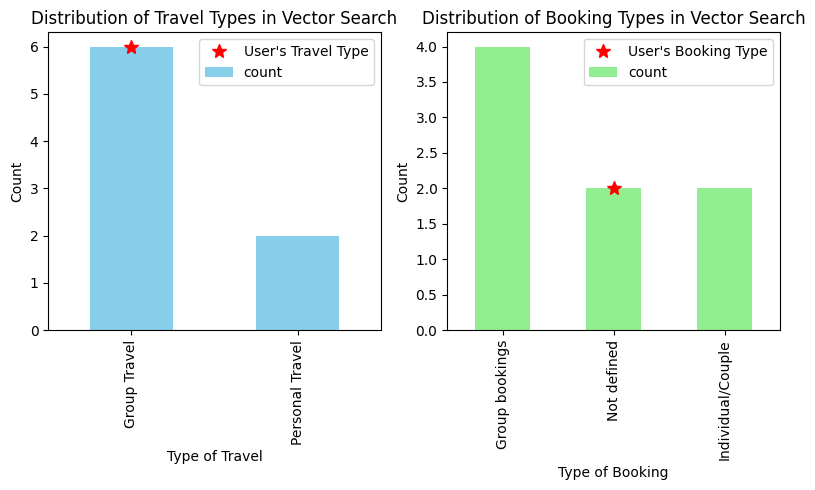



Retrieved information for customer 3398.


Retrieved information for hotels for city: London.

Generating user query embedding.
User embedding table user_search_embedding_3398_London_approach2 already exists. Skipping regeneration.

✅ User query embedding generation completed.3 Result available in table user_search_embedding_3398_London_approach2
⏱ Execution time[User Query Embedding]: 0.8271 seconds

✅ User preference generation completed.1 Result available in table user_preferences_3398
⏱ Execution time[User Preferences]: 0.6475 seconds


✅ Vector Search completed for user 3398 with count: 19 (max 1 per hotel_id)
⏱ Execution time[Vector Search]: 0.8375 seconds





### Comparison between vector search result and closest customer review



City,Hotel ID,Hotel,Likeability Rating,Likeability Distance (with added weightage),Combined Review (from the matched hotel result),Customer's Positive Review,Customer's Negative Review,Hotel Average Rating,Review Overall Rating
London,338,Park Plaza Victoria London,9.0 / 10,13.229088,Positive Review: friendly staff nice big rooms clean location,the personal was friendly in the hotel and the room was nice and big,there is nothing to complain in the hotel,8.6,10.0
London,706,Grange Wellington Hotel,8.1 / 10,11.787730,Positive Review: staff very helpful,Staff extremely accommodating and helpful,Entrance terrible with roadworks outside making it difficult for elderly especially one slightly disabled have to walk to taxi,8.8,9.6
London,626,New Linden Hotel,8.1 / 10,11.783836,Negative Review: Room was rather cold esppecially the bathroom | Positive Review: staff extremely helpful,Staff extremely accommodating and helpful,Entrance terrible with roadworks outside making it difficult for elderly especially one slightly disabled have to walk to taxi,7.6,9.6
London,555,St Martins Lane A Morgans Original,7.8 / 10,11.227485,Negative Review: in room free wifi was a bit slow | Positive Review: very nice hotel with friendly staffs,the personal was friendly in the hotel and the room was nice and big,there is nothing to complain in the hotel,9.0,10.0
London,1311,The May Fair Hotel,7.8 / 10,11.175936,Positive Review: staff extremely helpful and accommodating,Staff extremely accommodating and helpful,Entrance terrible with roadworks outside making it difficult for elderly especially one slightly disabled have to walk to taxi,8.4,10.0
London,249,DoubleTree by Hilton London Victoria,7.5 / 10,10.730039,Positive Review: nice rooms friendly staff,the personal was friendly in the hotel and the room was nice and big,there is nothing to complain in the hotel,8.4,7.5
London,273,The Royal Horseguards,7.3 / 10,10.423964,Positive Review: hotel location and breakfast are well room size is not small ad comfortable and staff are kind,the personal was friendly in the hotel and the room was nice and big,there is nothing to complain in the hotel,8.9,9.2
London,117,London Marriott Hotel Regents Park,7.3 / 10,10.387730,Positive Review: staff very helpful,Staff extremely accommodating and helpful,Entrance terrible with roadworks outside making it difficult for elderly especially one slightly disabled have to walk to taxi,8.3,9.2
London,423,The Queens Gate Hotel,7.1 / 10,9.987730,Negative Review: breakfast | Positive Review: staff very helpful,Staff extremely accommodating and helpful,Entrance terrible with roadworks outside making it difficult for elderly especially one slightly disabled have to walk to taxi,8.2,8.8
London,413,DoubleTree by Hilton London Westminster,7.1 / 10,10.087730,Negative Review: lots of breakfast but quality of food being kept warm disappointing | Positive Review: staff very helpful,Staff extremely accommodating and helpful,Entrance terrible with roadworks outside making it difficult for elderly especially one slightly disabled have to walk to taxi,8.5,7.9






[Reviews from the likeability hotels[For explainability]]
------------------------------------------------------------


Likeability Score,Hotel ID,Hotel,Result Travel Type,Cust Travel Type,Result Booking Type,Cust Booking Type
8.958287,338,Park Plaza Victoria London,Personal Travel,Personal Travel,Individual/Couple,Individual/Couple
8.110430,706,Grange Wellington Hotel,Group Travel,Personal Travel,Individual/Couple,Individual/Couple
8.108139,626,New Linden Hotel,Personal Travel,Personal Travel,Individual/Couple,Individual/Couple
7.780873,555,St Martins Lane A Morgans Original,Group Travel,Personal Travel,Individual/Couple,Individual/Couple
7.750551,1311,The May Fair Hotel,Group Travel,Personal Travel,Group bookings,Individual/Couple
7.488258,249,DoubleTree by Hilton London Victoria,Personal Travel,Personal Travel,Individual/Couple,Individual/Couple
7.308214,273,The Royal Horseguards,Group Travel,Personal Travel,Group bookings,Individual/Couple
7.286900,117,London Marriott Hotel Regents Park,Group Travel,Personal Travel,Group bookings,Individual/Couple
7.110430,413,DoubleTree by Hilton London Westminster,Personal Travel,Personal Travel,Individual/Couple,Individual/Couple
7.051606,423,The Queens Gate Hotel,Group Travel,Personal Travel,Individual/Couple,Individual/Couple



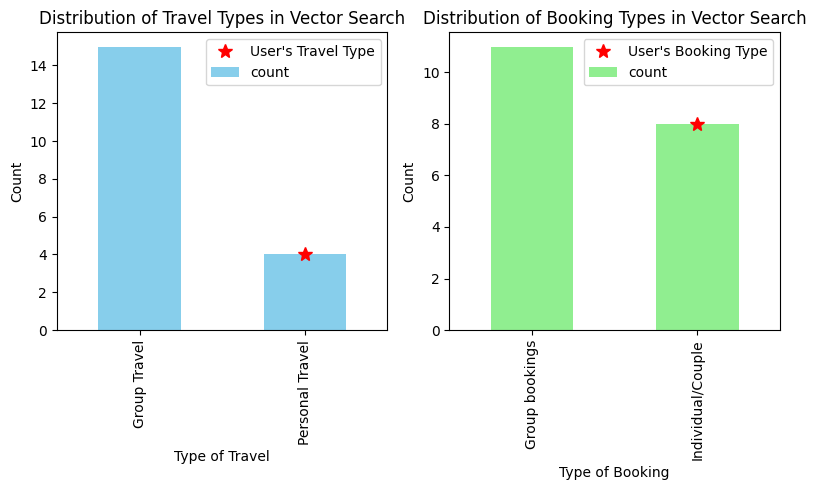



Retrieved information for customer 3398.


Retrieved information for hotels for city: Amsterdam.

Generating user query embedding.
User embedding table user_search_embedding_3398_Amsterdam_approach2 already exists. Skipping regeneration.

✅ User query embedding generation completed.3 Result available in table user_search_embedding_3398_Amsterdam_approach2
⏱ Execution time[User Query Embedding]: 0.7527 seconds

✅ User preference generation completed.1 Result available in table user_preferences_3398
⏱ Execution time[User Preferences]: 0.6960 seconds


✅ Vector Search completed for user 3398 with count: 17 (max 1 per hotel_id)
⏱ Execution time[Vector Search]: 0.7404 seconds





### Comparison between vector search result and closest customer review



City,Hotel ID,Hotel,Likeability Rating,Likeability Distance (with added weightage),Combined Review (from the matched hotel result),Customer's Positive Review,Customer's Negative Review,Hotel Average Rating,Review Overall Rating
Amsterdam,803,Apollofirst Boutique Hotel,8.7 / 10,12.801526,Positive Review: very helpful staff,Staff extremely accommodating and helpful,Entrance terrible with roadworks outside making it difficult for elderly especially one slightly disabled have to walk to taxi,8.5,9.6
Amsterdam,913,Jaz Amsterdam,8.4 / 10,12.202946,Positive Review: staff helpful,Staff extremely accommodating and helpful,Entrance terrible with roadworks outside making it difficult for elderly especially one slightly disabled have to walk to taxi,8.9,10.0
Amsterdam,1290,Hotel Esther a,7.8 / 10,11.233243,Negative Review: nothing | Positive Review: the room was excellent and friendly staff,the personal was friendly in the hotel and the room was nice and big,there is nothing to complain in the hotel,9.1,10.0
Amsterdam,1304,Ramada Apollo Amsterdam Centre,7.8 / 10,11.202659,Positive Review: freindley staff and very helpful,Staff extremely accommodating and helpful,Entrance terrible with roadworks outside making it difficult for elderly especially one slightly disabled have to walk to taxi,8.2,10.0
Amsterdam,908,Park Plaza Victoria Amsterdam,7.2 / 10,10.227242,Negative Review: Nothing at all | Positive Review: Friendly staff and room is clean n big,the personal was friendly in the hotel and the room was nice and big,there is nothing to complain in the hotel,8.0,10.0
Amsterdam,1209,Andaz Amsterdam Prinsengracht A Hyatt Hotel,7.2 / 10,10.212393,Negative Review: none | Positive Review: staff is nice and helpful,Staff extremely accommodating and helpful,Entrance terrible with roadworks outside making it difficult for elderly especially one slightly disabled have to walk to taxi,9.3,10.0
Amsterdam,1187,M venpick Hotel Amsterdam City Centre,7.2 / 10,10.187730,Negative Review: breakfast too expensive | Positive Review: staff very helpful,Staff extremely accommodating and helpful,Entrance terrible with roadworks outside making it difficult for elderly especially one slightly disabled have to walk to taxi,8.4,10.0
Amsterdam,1013,Bilderberg Hotel Jan Luyken,7.1 / 10,10.028943,Positive Review: staff was very helpful and friendly and location is great and room was a nice size,the personal was friendly in the hotel and the room was nice and big,there is nothing to complain in the hotel,8.3,8.8
Amsterdam,790,Corendon Vitality Hotel Amsterdam,7.1 / 10,10.132448,Positive Review: Good rooms nice hotel and friendly team,the personal was friendly in the hotel and the room was nice and big,there is nothing to complain in the hotel,8.4,7.9
Amsterdam,1009,Room Mate Aitana,6.7 / 10,9.430591,Negative Review: expensive breakfast | Positive Review: nice staff and big rooms,the personal was friendly in the hotel and the room was nice and big,there is nothing to complain in the hotel,8.8,9.2






[Reviews from the likeability hotels[For explainability]]
------------------------------------------------------------


Likeability Score,Hotel ID,Hotel,Result Travel Type,Cust Travel Type,Result Booking Type,Cust Booking Type
8.706780,803,Apollofirst Boutique Hotel,Personal Travel,Personal Travel,Individual/Couple,Individual/Couple
8.354674,913,Jaz Amsterdam,Group Travel,Personal Travel,Individual/Couple,Individual/Couple
7.784261,1290,Hotel Esther a,Group Travel,Personal Travel,Individual/Couple,Individual/Couple
7.766270,1304,Ramada Apollo Amsterdam Centre,Group Travel,Personal Travel,Group bookings,Individual/Couple
7.192495,908,Park Plaza Victoria Amsterdam,Group Travel,Personal Travel,Group bookings,Individual/Couple
7.183761,1209,Andaz Amsterdam Prinsengracht A Hyatt Hotel,Group Travel,Personal Travel,Group bookings,Individual/Couple
7.169253,1187,M venpick Hotel Amsterdam City Centre,Group Travel,Personal Travel,Group bookings,Individual/Couple
7.136734,790,Corendon Vitality Hotel Amsterdam,Group Travel,Personal Travel,Individual/Couple,Individual/Couple
7.075849,1013,Bilderberg Hotel Jan Luyken,Group Travel,Personal Travel,Group bookings,Individual/Couple
6.723877,1009,Room Mate Aitana,Group Travel,Personal Travel,Group bookings,Individual/Couple



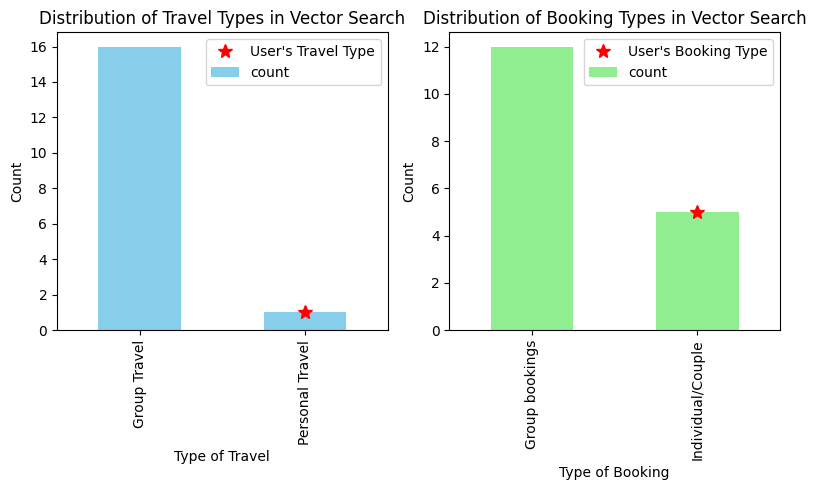

In [ ]:
def mono_centered(text: str):
  display(HTML(f"<pre style='text-align:center; font-family: monospace'>{text}</pre>"))

def banner(project_name: str, tagline: str):
  display(HTML(f"""
    <div style="
        background-color:#2C3E50; color:#ECF0F1; padding:20px; text-align:center;
        border-radius:12px; font-size:24px; font-weight:bold; font-family:Verdana, sans-serif;
        box-shadow: 0 4px 12px rgba(0,0,0,0.15);
    ">
    🏨 {project_name}
    </div>
    <div style="
    background-color:#5c88d8; color:white; padding:12px;
    text-align:center; border-radius:0 0 12px 12px; font-size:16px; font-style:italic;
    font-family:Verdana, sans-serif; box-shadow: 2px 2px 8px rgba(0,0,0,0.1);
    ">
    ✨ {tagline} ✨
    </div>

    """))

if __name__ == "__main__":
    banner("SEMANTIC HOTEL LIKEABILITY RANKER", "Ranking hotels the way travellers actually experience them.")

    # Shared configuration
    config = Config(
        project_id="vf-it-aib-prd-hr-ask-web-nl",
        dataset_id="bq_ai_hackathon",
        region="europe-west1",
        embedding_model="text_embedding_model"
    )

    mono_centered(f"\n\n################################################################\n")
    mono_centered(f" ⚙️ Initiating Backend process - Pre-requisite one-off processing.")
    mono_centered(f"\n#################################################################")

    # Step 1: Generate master embeddings
    manager = EmbeddingManager(config)
    manager.create_master_embeddings()
    manager.create_index()

    mono_centered(f"\n\n#################################################################\n")
    mono_centered(f"Backend processing finished.")
    mono_centered(f"\n#################################################################")
    mono_centered("\n\n----------------------------------------------------------------------------------------------------------")

    mono_centered(f"\n\n#################################################################\n")
    mono_centered(f"Initiating Frontend User Journey. This will be unique for each user.")
    mono_centered(f"\n#################################################################")

    # this will simulate the scenario, that the user has come a website and we have extracted some details to find the similar hotels for his next journey
    users_scenarios = [
        {"customer_id":"10634","destination_country":"Netherlands","destination_city":"Amsterdam","description":"User with 1 previous review and travelling to the same previous city again."},
        {"customer_id":"3398","destination_country":"United Kingdom","destination_city":"London","description":"User with 3 previous reviews and travelling to one of the previous city again."},
        {"customer_id":"3398","destination_country":"Netherlands","destination_city":"Amsterdam","description":"User with 3 previous reviews and travelling to a new city."},
        # {"customer_id":"42711","destination_country":"Netherlands","destination_city":"Amsterdam","description":"User with 30 previous reviews and travelling to a new city."},
        # {"customer_id":"29722","destination_country":"Netherlands","destination_city":"Amsterdam","description":"User with few previous reviews"},
        # {"customer_id":"29877","destination_country":"Netherlands","destination_city":"Amsterdam","description":"User with lots of previous reviews"},
        # {"customer_id":"33374","destination_country":"Netherlands","destination_city":"Amsterdam","description":"User with 2 previous reviews"},
        # {"customer_id":"33374","destination_country":"Austria","destination_city":"Vienna","description":"User without previous reviews"},
        # {"customer_id":"3398","destination_country":"Austria","destination_city":"Vienna","description":"User with 3 previous reviews"}

    ]

    user_fetcher = UserFetcher(config)
    hotel_fetcher = HotelFetcher(config)
    query_embedder = QueryEmbedder(config)
    user_pref_gen = UserPreferenceGenerator(config)

    searcher = SemanticSearcher(config, read_user_query_embedding_from_table=True)
    ranker = Ranker(config)
    visualizer = Visualizer(config)

    hotel_embeddings_cache = {}

    for picked_user in users_scenarios:
      user_id = picked_user["customer_id"]
      user_city = picked_user["destination_city"]

      mono_centered(f"\n\n Simulating user journey for user - {user_id}")
      mono_centered(f"{picked_user['description']}")

      # Step 2: Get user previous reviews related to the new search
      user_all_info_df = user_fetcher.get_user_details(user_id)

      # gets user other details
      # user_query_text, user_required_info_df = user_fetcher.get_concatenated_details(user_all_info_df)

      # gets hotel details for customer city
      raw_hotel_df = hotel_fetcher.get_details(picked_user["destination_country"], user_city)

      # Step 3: Generate embedding for query
      query_embedding = query_embedder.embed_query(user_basic_info = picked_user, user_extra_info_df = user_all_info_df)

      # Step 4: generate user preferences, likes
      user_likes = user_pref_gen.get_preferences(picked_user)

      # Step 5: Perform semantic search
      vector_search_result = searcher.search_with_adjust_weights(user_basic_info = picked_user, top_k=500)
      vector_search_result = ranker.calculate_score(vector_search_result)

      # Step 6: Display result
      data={
          "user":picked_user
      }
      result={
          "user": user_all_info_df,
          "hotel": raw_hotel_df,
          "search_vector": vector_search_result,
          "preferences": user_likes
      }

      print("\n\n")
      visualizer.display_side_by_side_summary(data, result)
      mono_centered(f"\n\n#################################################################\n")
      mono_centered(f"\n\n EXPLAINABILITY SECTION")
      mono_centered(f"\n\n#################################################################\n\n\n")
      visualizer.display_user_search_info(data=data, result=result)
      print("\n\n")
      visualizer.display_likeability_table(data=data, result=result)
      print("\n\n")
      visualizer.display_other_attributes_as_table(data=data, result=result)
      print("\n\n")
      visualizer.plot_barcharts(data=data, result=result)


      mono_centered(f"\n\n User journey for user - {user_id} finished.\n\n")
      mono_centered("\n\n----------------------------------------------------------------------------------------------------------------------------------------")

    mono_centered(f"\n\n#################################################################\n")
    mono_centered(f"Frontend User Journey Simulation Completed.")
    mono_centered(f"\n#################################################################\n\n\n")

# SUMMARY
----------------------------------------------------
Semantic hotel ranking is one such use case where the application of embeddings have been shown. This can act as foundation for other use cases that includes (but not limiting to) personalization, advanced search, explainability, and predictive analytics. Essentially, any system that needs to match user intent with hotel attributes, reviews, or preferences can leverage these embeddings.

# FUTURE SCOPES
----------------------------------------------------
1. **Generating insights**
  - Using negative embeddings and user dislikes and this information can be useful for the hotel to rectify their services and overall ratings.

2. **Trend analysis**
  - Identify patterns in what features users value most by clustering embeddings.

3. **Customer segmentation**
  - Cluster user embeddings to discover new travel personas or market segments.

4. **Hybrid & Multi-Modal Recommendations**
  - Combine text + images + metadata: Extend embeddings to include
  hotel images, room layouts, and facilities for richer semantic comparisons.

5. **Sentiment-driven demand forecasting**
  - Predict hotel popularity or likelihood of bookings based on
  aggregated review embeddings.

6. **Churn prediction**
 - Analyze user embeddings to predict which users might stop booking and target retention campaigns.

7. **Integration with Other AI Systems**
  - *Chatbots / virtual assistants*: Allow users to have natural-language hotel queries answered using embeddings.